# Exploring representation bias of countries in Wikipedia using the Wikispeedia Dataset

## Project Milestone 3

### Research Questions: 
* Is there a representation bias in Wikipedia about countries?
* What does the behaviour of the players tell us about their cultural knowledge about countries?

### Notebook structure

- Data wrangling
- Data analysis
    - Part 1: Descriptive statistics and naive statistical analysis of the Wikispeedia Dataset
        * 1.1. Exploratory data analysis
        * 1.2 Length of the articles* and their number of hyperlinks
        * 1.3: Sentiment analysis of articles*
    - Part 2: Descriptive statistics and naive statistical analysis about the behaviour of the players
        * 2.1. How different is the ratio of finished pathways, where articles* are the start/target?
        * 2.2. How different is the length of the pathway taken respectively the time needed, where articles* are the start/target?
        * 2.3. How often does an article* appear in a pathway where it is neither the start nor the traget?
    - Part 3: Analysis of biases
        * A: Establish baseline (e.g. expected length for world mean population or economic strength)
        * B: By investigating article length, article sentiment or number of hyperlinks while controlling for e.g. population size, economic power or if English is an official language, is there a representation bias based on countries in Wikipedia?  
        * C: While controlling for as much of the bias in the dataset as we can, do we see additional bias of the players in the pathways they have taken? -> cultural bias (how much do players know about countries, since we can not conclude anything without demographic informations about the players)

    *articles = Wikipedia article of a country
    
    To compare all countries (more than 200) would be too confusing, therefore they are grouped by region, economic developement and population to plot the graphs.

In [1]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from urllib.parse import unquote
import plotly.express as px
import statsmodels.api as sm

# import helper functions from python script
import helper as hlp
import sentiment_analysis as sa


## Loading & cleaning data
The data used in this notebook comes both from the Wikispeedia data set and from the UN, which is used to classify the countries. Each csv, file is parsed ina readable format, unnecessary columns are removed.



In [2]:
articles_load =  pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"], skiprows=12)
links_load = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished_load = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished_load = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_load = np.loadtxt("data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)
categories_load = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=["article", "category"], skiprows = 13)

# The sentiment analysis was done on a different notebook for more efficiency
sentiment_analysis_of_countries_load =  pd.read_csv("data/sentiment_analysis.csv")

# seperate each row and create a matrix with all the shortest distance
table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_load])

# load, keep only necessery columns and rename them
UN_countries_load = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')
UN_countries_load = UN_countries_load[['Region Name', 'Sub-region Name','Intermediate Region Name', 'Country or Area',
                                       'Least Developed Countries (LDC)', 'Land Locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)']]
UN_countries_load.columns = ['Region Name', 'Sub-region Name','Intermediate Region Name', 'Country',
                                       'LDC', 'LLDC', 'SIDS']

UN_countries_by_economies_load = pd.read_csv("data/countries_by_income_category.csv")
UN_countries_by_economies_load.columns = ['Country', 'Economic classification']

UN_countries_by_population_load = pd.read_csv("data/UNdata_population_size.csv")

# Translating all article titles to user readable format
articles_load['article'] = articles_load['article'].apply(unquote)
links_load['link_source'] = links_load['link_source'].apply(unquote)
links_load['link_target'] = links_load['link_target'].apply(unquote)
paths_finished_load['path'] = paths_finished_load['path'].apply(unquote)
paths_unfinished_load['path'] = paths_unfinished_load['path'].apply(unquote)
paths_unfinished_load['target'] = paths_unfinished_load['target'].apply(unquote)
categories_load['article'] = categories_load['article'].apply(unquote)

## 0. Data wrangling 
The imported data is transformed and merged into several pd.DataFrames, that are needed for the data analysis

1. path_overview: combines information about all the path of all games played (unfinished and finished)
2. main_categories: dataframe that contains the main category of all Wikipedia articles
3. country_regions_df: dataframe that contains the region a country belongs to
4. UN_countries_by_economies: contains economic classifications per country
5. plaintext_articles: contains the whole content of Wikipedia articles about countries
6. sentiment_analysis_of_countries: contains results from sentiment analysis of countries Wikipedia article
7. UN_countries_by_population: contains the population of each country in 2014
8. country_links_df: contains for each Wikipedia article the number of hyperlink in and out
9. country_path_overview: contains all games played (= pathways), where the target was a country. The dataframe is also populated with the region and the economic classification of the target country.



### 0.1. Create path_overview_df dataframe


In [3]:
# expand the finished paths
paths_finished = paths_finished_load.copy()
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
paths_unfinished = paths_unfinished_load.copy()
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]

articles = articles_load.copy()
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: hlp.find_path_distance(row['source'], row['target'], help_articles, table_distance), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))

# Translating article names from URL to latin characters
path_overview['source'].apply(unquote)
path_overview['target'].apply(unquote)

# Rename and reste index
path_overview_df = path_overview.copy()

# Changes names to be consitent from United_States to United States
path_overview_df['source'] = [el.replace('_',' ') for el in path_overview_df['source']]
path_overview_df['target'] = [el.replace('_',' ') for el in path_overview_df['target']]

display(path_overview_df)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type
0,14th century,African slave trade,6a3701d319fc3754,1297740409,3.0,166,8,True,NaN,NaN
1,14th century,African slave trade,3824310e536af032,1344753412,3.0,88,4,True,3.0,NaN
2,14th century,African slave trade,415612e93584d30e,1349298640,3.0,138,7,True,NaN,NaN
3,14th century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN
4,14th century,John F. Kennedy,015245d773376aab,1366730828,3.0,175,6,True,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
76188,Franz Kafka,Cholera,109ed71f571d86e9,1389787605,3.0,180,7,False,NaN,restart
76189,Modern history,Hollandic,232f992e57d43e8d,1389787697,3.0,6,0,False,NaN,restart
76190,Computer programming,The Beatles,2e09a7224600a7cd,1389798400,3.0,1900,4,False,NaN,timeout
76191,Jamaica,Alan Turing,60af9e2138051b96,1389799481,3.0,1903,3,False,NaN,timeout


### 0.2. Create main_categories_df dataframe

In [4]:
# Apply the custom function hlp.extract_subject_category() to create a new 'subject_category' column
categories = categories_load.copy()
categories['subject_category'] = categories['category'].apply(hlp.extract_subject_category)

# Create a dataframe with only the relevant columns and remove _
categories['article'] = [el.replace('_',' ') for el in categories['article']]
main_categories_df = categories[['article', 'subject_category']]

# Remove People's Republic of China (we only keep China)
main_categories_df = main_categories_df.drop(main_categories_df[main_categories_df['article'] == "People's Republic of China"].index)

# Display the new DataFrame
main_categories_df.head()

,article,subject_category
0,Áedán mac Gabráin,History
1,Áedán mac Gabráin,People
2,Åland,Countries
3,Åland,Geography
4,Édouard Manet,People


### 0.3. Create country_regions_df dataframe
Below we find the articles which have different names to those outlined in the UN dataset. We then manually found the corresponding name in the UN dataset and created a dictionary to map article names -> UN dataset name. We also remove places that are not countries (e.g. Dubai or Abu Dhabi) and replace the country name when necessary.

In [5]:
UN_countries = UN_countries_load.copy()

countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
countries = [cntry.replace('_',' ') for cntry in countries]

# United Arab Emirates Problem -> Abu Dhabi / Dubai are not countries etc. 
# If confusion, the country with biggest population is kept
countries_to_remove = ['Abu Dhabi', 'Dubai', 'Easter Island', 'Galápagos Islands', 'Korea', 'Abkhazia', 'Republic of China', 'Éire', 'Republic of Ireland']
countries = [cntry for cntry in countries if cntry not in countries_to_remove]

countries_missing = []
for country in countries:
    country = country.replace('_',' ')
    if country not in UN_countries['Country'].values:
        countries_missing.append(country)

# "China Problem" we keep Taiwan  -> Taiwan, Republic of China -> deleted (same as Taiwan),
# Tibet -> Tibet, People's Republic of China -> China (already done in 2)

replacement_country_names = [
    'Åland Islands', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia',
    'Timor-Leste', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'Tibet', 'Türkiye', 'Turkish Republic of Northern Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

# Dict style is key: value -> Wikipedia name: UN name
replacement_countries = dict(zip(countries_missing, replacement_country_names))

# Creating a dictionary to map each country to its region
country_to_region = {}

for country in countries:
    country_to_region[country] = hlp.get_region(country, UN_countries, replacement_countries)

# Add manually countries that are not present in the UN dataframe
country_to_region['Kosovo'] = 'Eastern Europe'
country_to_region['South Ossetia'] = 'Western Asia'
country_to_region['Tibet'] = "Central Asia"
country_to_region['Turkish Republic of Northern Cyprus'] = "Southern Europe"

country_region_df = pd.DataFrame.from_dict(country_to_region, 
                                           orient='index',
                                           dtype=None,
                                           columns=['region'])

country_region_df.reset_index(inplace=True)
country_region_df.rename(columns={"index": "article"}, inplace=True)

# Rename Latin America and the Caribbean to Latin America
country_region_df['region'] = country_region_df['region'].replace('Latin America and the Caribbean', 'Latin America')
country_region_df.columns = ['Country', 'Region']
display(country_region_df)

,Country,Region
0,Åland,Northern Europe
1,Afghanistan,Southern Asia
2,Albania,Southern Europe
3,Algeria,Northern Africa
4,Andorra,Southern Europe
...,...,...
214,West Bank,Western Asia
215,Western Sahara,Northern Africa
216,Yemen,Western Asia
217,Zambia,Sub-Saharan Africa


### 0.4. Create UN_countries_by_economies dataframe
Similarly, we match the article country names to their economic classification. 

In [6]:
# hard coded changes in country names that can't be read properly from the .csv file
read_csv_names = ['Turkiye', 'China Hong Kong Special Administrative Region', 'Cote d Ivoire']
new_names = ["Türkiye", "China, Hong Kong Special Administrative Region", "Côte d’Ivoire"]
UN_to_modify = UN_countries_by_economies_load.copy()
for i in range(len(read_csv_names)-1):
    country_index = np.where(UN_countries_by_economies_load['Country']==read_csv_names[i])[0][0]
    UN_to_modify.at[country_index, 'Country'] = new_names[i]

UN_countries_by_economies = pd.merge(UN_countries, UN_to_modify, how='left', on='Country')[['Country', 'LDC', 'LLDC', 'SIDS', 'Economic classification']]

# Show countries that are missing an economic classification (should be 248-163=85)
missing_countries = UN_countries_by_economies[UN_countries_by_economies['Economic classification'].isna()]['Country'].values

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_economies['Country'] = UN_countries_by_economies['Country'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_economies['Country'])
UN_countries_by_economies = UN_countries_by_economies.sort_values('Country').reset_index(drop=True)

# Check if everything went fine
display(UN_countries_by_economies)

,Country,LDC,LLDC,SIDS,Economic classification
0,Afghanistan,x,x,NaN,Low-income
1,Albania,NaN,NaN,NaN,Upper middle income
2,Algeria,NaN,NaN,NaN,Upper middle income
3,American Samoa,NaN,NaN,x,NaN
4,Andorra,NaN,NaN,NaN,NaN
...,...,...,...,...,...
244,Western Sahara,NaN,NaN,NaN,NaN
245,Yemen,x,NaN,NaN,Lower middle income
246,Zambia,x,x,NaN,Lower middle income
247,Zimbabwe,NaN,x,NaN,Low-income


### 0.5. Create plaintext_articles_df dataframe
For the plaintext articles dataframe we create a np.array with name of all articles that are about a country and replace spaces by underscores to be able to read the names (e.g United States -> United_States). After correctly reading the file, we write back the country names with spaces when needed instead of the underscores.

In [7]:
countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
countries = [cntry.replace(' ','_') for cntry in countries]

path = "data/plaintext_articles/" 
data = []

for country in countries:
    file_path = path + country + '.txt'

# Open the file and read its content into a string
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            load_file_content = file.read()
            file_content = load_file_content[15:].replace("\n\n2007 Schools Wikipedia Selection", "")

    # Add filname, content and article length to the data list
        data.append((country, file_content, len(file_content)))

plaintext_articles = pd.DataFrame(data, columns=['Country', 'Article content', 'Article length'])
plaintext_articles['Country'] = [cntry.replace('_',' ') for cntry in plaintext_articles['Country']]
display(plaintext_articles)

,Country,Article content,Article length
0,Abkhazia,Abkhazia. Related subjects: Asian Countries;\n...,33592
1,Abu Dhabi,Abu Dhabi. Related subjects: Countries; Middle...,12072
2,Afghanistan,Afghanistan. Related subjects: Asian Countries...,40240
3,Albania,Albania. Related subjects: Countries; European...,24203
4,Algeria,Algeria. Related subjects: African Countries;\...,34081
...,...,...,...
215,West Bank,West Bank. Related subjects: Countries; Middle...,38456
216,Western Sahara,Western Sahara. Related subjects: African Coun...,25959
217,Yemen,Yemen. Related subjects: Countries; Middle Eas...,28075
218,Zambia,Zambia. Related subjects: African Countries;\n...,31103


### 0.6. Create sentiment_analysis_of_countries dataframe
The sentiment analysis was done on a different file that can be found in the repository, for efficency purposes. Here, here we load the result of the analysis. We add the sentiment score as _sentiment score = (1 * nbr_pos_batch + 0 * nbr_neu_batch - 1 * nbr_neg_batch) / total_batches_ . We also fix the underscore and space issue.

In [8]:
sentiment_analysis_of_countries=sentiment_analysis_of_countries_load.copy().drop('Unnamed: 0', axis='columns')

sentiment_analysis_of_countries['sentiment score'] = sentiment_analysis_of_countries.copy().apply(
    lambda row: (row.POS_sum - row.NEG_sum) / (row.NEG_count + row.NEU_count + row.POS_count), axis=1)

sentiment_analysis_of_countries['Country'] = [cntry.replace('_',' ') for cntry in sentiment_analysis_of_countries['Country']]
display(sentiment_analysis_of_countries)

,Country,Sentiment,NEG_count,NEG_sum,NEU_count,NEU_sum,POS_count,POS_sum,sentiment score
0,Abkhazia,NEU,23.0,16.881333,109.0,98.443426,2.0,1.381859,-0.115668
1,Abu Dhabi,NEU,4.0,3.016167,42.0,37.855860,3.0,1.977438,-0.021199
2,Afghanistan,NEU,27.0,22.140542,119.0,106.641921,15.0,11.823924,-0.064078
3,Albania,NEU,11.0,8.994323,78.0,67.856187,8.0,5.589544,-0.035101
4,Algeria,NEU,16.0,13.254207,111.0,97.182142,9.0,7.147486,-0.044902
...,...,...,...,...,...,...,...,...,...
215,West Bank,NEU,15.0,11.718062,135.0,121.900878,4.0,2.384537,-0.060607
216,Western Sahara,NEU,24.0,18.424562,79.0,70.846074,1.0,0.630308,-0.171099
217,Yemen,NEU,7.0,5.260394,102.0,91.418999,3.0,2.053402,-0.028634
218,Zambia,NEU,18.0,14.538703,104.0,94.602926,2.0,1.539113,-0.104835


### 0.7. Create UN_countries_by_population dataframe
The UN countries dataframe that also contains information about the population is sorted to keep only the population value and the country names are cleaned to match those of Wikispeedia.

In [9]:
UN_countries_by_population = UN_countries_by_population_load.copy()

# Get index of last country to remove commenting lines
zimbabwe_index = UN_countries_by_population[UN_countries_by_population['Country or Area'] == 'Zimbabwe'].index[0]
UN_countries_by_population = UN_countries_by_population.iloc[:(zimbabwe_index+1)]
UN_countries_by_population = UN_countries_by_population.drop_duplicates(subset='Country or Area', keep='first')

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_population['Country or Area'] = UN_countries_by_population['Country or Area'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_population['Country or Area'])
UN_countries_by_population = UN_countries_by_population.sort_values('Country or Area').reset_index(drop=True)

# Only keep needed columns and rename them
UN_countries_by_population = UN_countries_by_population[['Country or Area', 'Year','Value']]
UN_countries_by_population.columns = ['Country', 'Year','Value']
display(UN_countries_by_population)

,Country,Year,Value
0,Afghanistan,2014,2.655675e+07
1,Albania,2014,2.895947e+06
2,Algeria,2014,3.911428e+07
3,American Samoa,2014,6.181100e+04
4,Andorra,2014,7.015500e+04
...,...,...,...
215,West Bank,2014,4.429084e+06
216,Yemen,2014,2.595592e+07
217,Zambia,2014,1.502332e+07
218,Zimbabwe,2014,1.399347e+07


### 0.8. Create country_links_df dataframe

In [10]:
links_outdegree = links_load.copy()
links_outdegree.columns = ['article','link_out']
out_degrees = links_outdegree.groupby('article').count()
out_degrees.sort_values(by='link_out', ascending=False, inplace=True)

links_indegree = links_load.copy()
links_indegree.columns = ['link_in','article']
in_degrees = links_indegree.groupby('article').count()
in_degrees.sort_values(by='link_in', ascending=False, inplace=True)

link_counts = out_degrees.merge(in_degrees, how='outer', on='article')
link_counts.reset_index(inplace=True)

# Write United_States as United States
link_counts['article'] = [cntry.replace('_',' ') for cntry in link_counts['article']]

link_counts = link_counts.merge(country_region_df, left_on='article', right_on='Country', how='left')
country_links_df = (link_counts.dropna(subset=['Country']))[['article', 'link_out', 'link_in', 'Region']]
country_links_df.columns = ['Country', 'link_out', 'link_in', 'Region']

country_links_df.head()

,Country,link_out,link_in,Region
0,United States,294.0,1551.0,Northern America
7,Lebanon,192.0,114.0,Western Asia
9,Armenia,186.0,99.0,Western Asia
10,Georgia (country),180.0,84.0,Western Asia
12,Turkey,172.0,249.0,Western Asia


### 0.9. Create country_path_overview dataframe

In [11]:
countries = main_categories_df[main_categories_df['subject_category'] == 'Countries']['article'].values
country_path_overview = path_overview_df[path_overview_df['target'].isin(countries)]

country_path_overview = country_path_overview.merge(country_region_df, 
                                                    left_on='target', 
                                                    right_on='Country', 
                                                    how='left').drop(['Country'], axis=1)
country_path_overview = country_path_overview.merge(UN_countries_by_economies[['Country', 'Economic classification']],
                                                    left_on='target',
                                                    right_on= 'Country',
                                                    how= 'left').drop(['Country'], axis=1)

display(country_path_overview)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type,Region,Economic classification
0,14th century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN,Southern Europe,High-income
1,2005 Atlantic hurricane season,Spain,0d57c8c57d75e2f5,1287268005,1.0,22,3,True,1.0,NaN,Southern Europe,High-income
2,2005 Atlantic hurricane season,Liechtenstein,0ec465e516314a56,1249908585,2.0,391,5,True,2.0,NaN,Western Europe,NaN
3,2005 Atlantic hurricane season,Liechtenstein,1dbbba9e540a9b9b,1346912342,2.0,227,2,True,5.0,NaN,Western Europe,NaN
4,2005 Atlantic hurricane season,Sweden,2134400014dd016d,1366612470,2.0,53,4,True,NaN,NaN,Northern Europe,High-income
...,...,...,...,...,...,...,...,...,...,...,...,...
4727,Proton,Liechtenstein,1c495c3c72396b19,1388389488,3.0,96,2,False,NaN,restart,Western Europe,NaN
4728,Scotland in the High Middle Ages,Jamaica,405a17d643fa8160,1388625809,2.0,1809,0,False,NaN,timeout,Latin America,Upper middle income
4729,Vanadium,Latvia,580bea917fbb4ced,1389370284,2.0,52,0,False,NaN,restart,Northern Europe,High-income
4730,Literacy,Kyrgyzstan,23f7c6281660209f,1389494317,2.0,679,17,False,NaN,restart,Central Asia,Low-income


### 0.10 Putting it all together for the plots
For the different plots of the datastory, we will also use the following dataframe and dictionnaries.

In [12]:
plot_df = UN_countries_by_population.merge(country_region_df, on='Country').drop(columns=['Year'])
plot_df = plot_df.merge(UN_countries_by_economies, on='Country').drop(columns=['LDC','LLDC','SIDS'])
plot_df = plot_df.merge(country_links_df, on='Country').drop(columns=['Region_y'])
plot_df = plot_df.rename(columns={'Value':'Population','Region_x':'Region', 'link_out':'Link out','link_in':'Link in'})
article_lengths = plaintext_articles.drop(columns=['Article content'])
plot_df = plot_df.merge(article_lengths, on='Country')
plot_df.to_csv('data/plot_df.csv')

economic_classification_order = {
    'Low-income': 1,
    'Lower middle income': 2,
    'Upper middle income': 3,
    'High-income': 4
}
color_scheme = {
    'Low-income': '#4328e7',
    'Lower middle income': '#ff6283',
    'Upper middle income': '#9654e5',
    'High-income': '#ff8800'
}

## Data analysis
## Part 1:
Now that the different dataframes have been prepared using cleaned data, we can focus on some descriptive statistics and naive statistical analysis about the Wikispeedia dataset.

1. Introductory analysis
2. Length of Wikipedia articles
3. Hyperlinks of Wikipedia articles
4. Sentiment analysis of Wikipedia articles
5. Compare Wikispeedia statistics to population size


### 1.1. Introductory analysis

Plotting the distribution of countries in the dataset based on their region.
All countries that are recognized by the UN are included in our dataset.

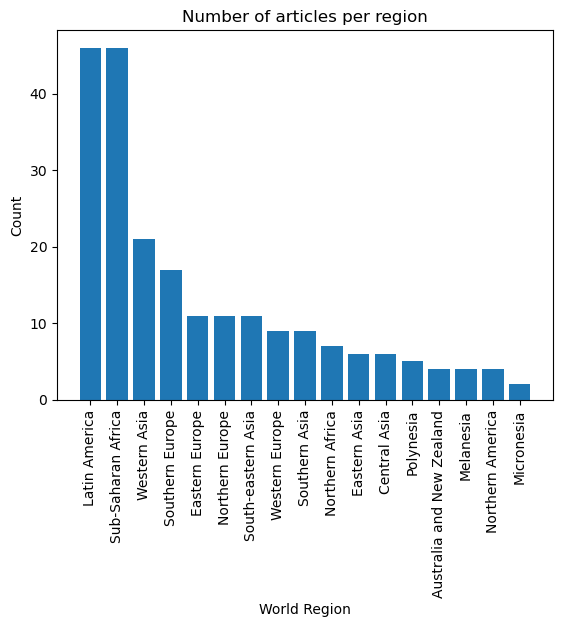

In [13]:
countries_per_region = ((country_region_df.groupby('Region').count()).reset_index()).sort_values(by='Country', ascending=False)

plt.bar(countries_per_region['Region'], countries_per_region['Country'])
plt.xticks(rotation=90)
plt.title("Number of articles per region")
plt.xlabel("World Region")
plt.ylabel("Count")
plt.show()

We can see that there are more than 40 articles for Latin America and sub-Saharan Africa and around 10 articles for the rest of the world regions. 

Plotting the distribution of countries in the dataset based on their economic classification. We can see that the countries are almost evenly distributed among the different income groups, with slighty more articles when the economic classification is high.

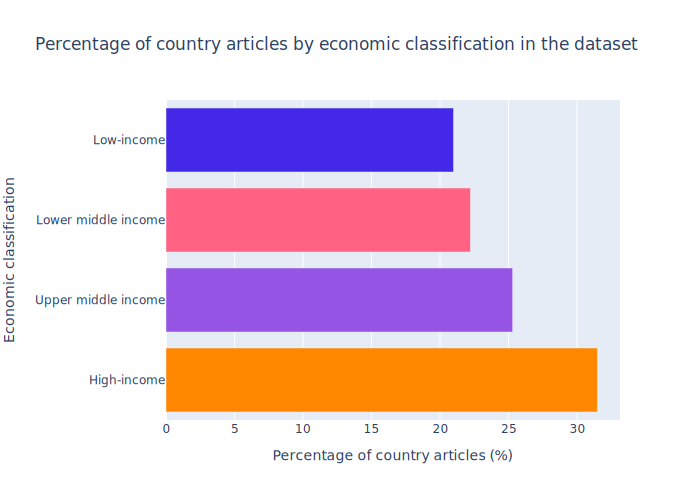

In [14]:
countries_per_economie = (UN_countries_by_economies.groupby('Economic classification').count()).reset_index()
countries_per_economie.columns = ['Economic_classification', 'Country','Least Developed Countries (LDC)',
                                    'Land Locked Developing Countries (LLDC)','Small Island Developing States (SIDS)']
total_countries = countries_per_economie['Country'].sum()
countries_per_economie['percentage'] = countries_per_economie.apply(lambda row: row.Country / total_countries * 100, axis=1)
countries_per_economie['Economic order'] = countries_per_economie['Economic_classification'].map(economic_classification_order)

fig = px.bar(countries_per_economie.sort_values(by='Economic order'), x="percentage",y="Economic_classification",orientation='h', title='Percentage of country articles by economic classification in the dataset',
             color='Economic_classification', color_discrete_map=color_scheme,
            labels={'Economic_classification':'Economic classification','percentage':'Percentage of country articles (%)'},
            hover_data={'percentage':True, 'Economic_classification':False}, hover_name="Economic_classification")
fig.update_layout(showlegend=False)
fig.write_html("plots/percentage_economic_classification.html")
fig.show('svg')


### 1.2. Length of Wikipedia articles

We now look at the length of the different articles. Intuitively, the longer an article about a country the better represented it is.

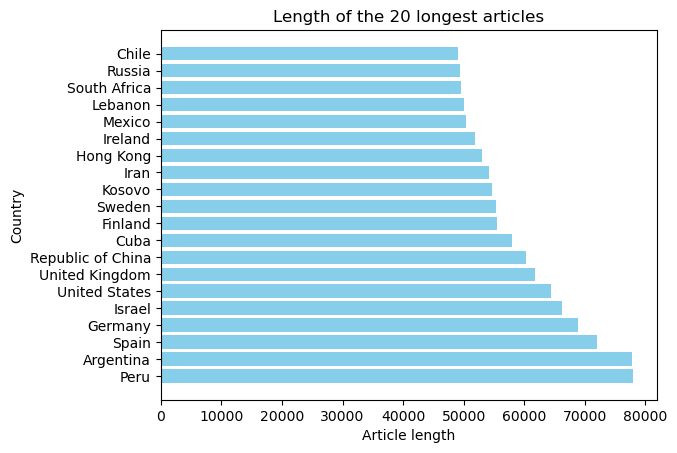

In [15]:
sorted_articles = plaintext_articles.sort_values(by='Article length', ascending=False)
plt.barh(sorted_articles.iloc[:20]['Country'], sorted_articles.iloc[:20]['Article length'], color='skyblue')
plt.ylabel('Country')
plt.xlabel('Article length')
plt.title('Length of the 20 longest articles')
plt.show()

We group the data by economic classification and calculate the mean of the article length for each category, to get a sense of the distribution. 

In [16]:
merged_length = sorted_articles.merge(country_region_df, on='Country').merge(UN_countries_by_economies, on='Country')
merged_length['Economic order'] = merged_length['Economic classification'].map(economic_classification_order)

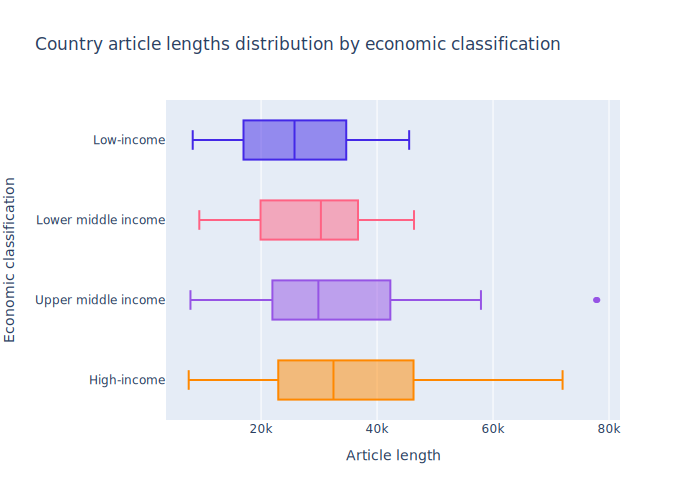

In [17]:
fig = px.box(merged_length.sort_values(by='Economic order', ascending=True),
x="Article length", y="Economic classification", color='Economic classification', color_discrete_map=color_scheme,
hover_data=["Country"], title='Country article lengths distribution by economic classification')
fig.update_layout(showlegend=False)
fig.write_html('plots/article_length_economic.html')
fig.show('svg')

Articles of high income classified countries appears to be slighty longer than articles of low income classified countries. But as a whole the articles are between 20'000 and 40'000. 

We now evaluate the article length distribution by world regions. For the plot to be more readable we order the regions by the median article length.

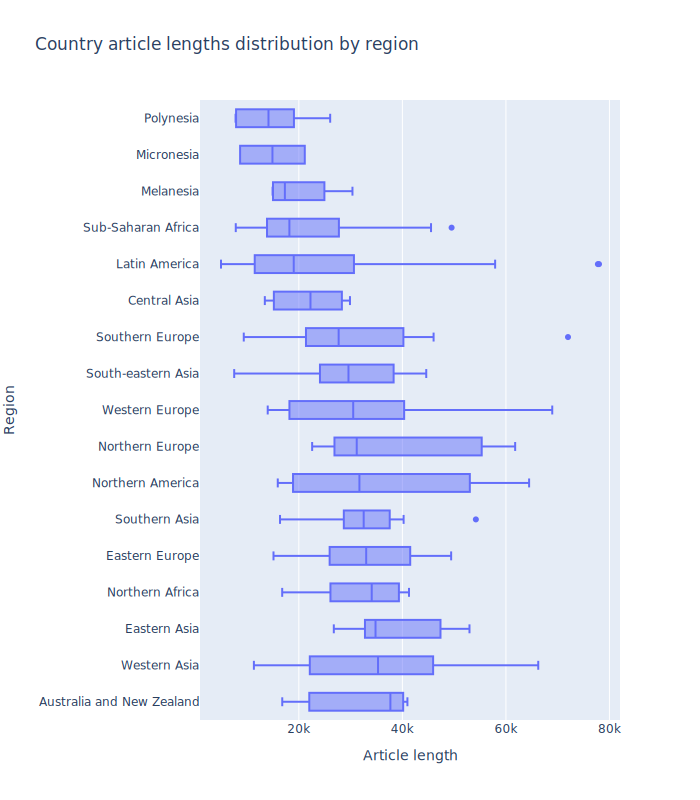

In [18]:
# Compute the median for each region
median_region_lengths = merged_length.groupby('Region')['Article length'].median().reset_index()
median_region_lengths.rename(columns={'Article length': 'Region median article length'}, inplace=True)

# Add median value to original df
merged_length_median = pd.merge(merged_length, median_region_lengths, on='Region', how='left')

fig = px.box(merged_length_median.sort_values(by='Region median article length', ascending=False),
             x="Article length", y="Region", height = 800, hover_data=["Country"], 
             title='Country article lengths distribution by region')
fig.update_layout(showlegend=False)
fig.write_html('plots/article_length_region.html')
fig.show('svg')

### 1.3. Number of hyperlinks

Hyperlinks are a key part of Wikipedia articles, they allow for the credibility of the content. They are also a mean to evaluate the how well an article is connected to the network of articles. A high number of links in means that a high number of pages lead to the article where as a low number means that very few articles lead to it. 

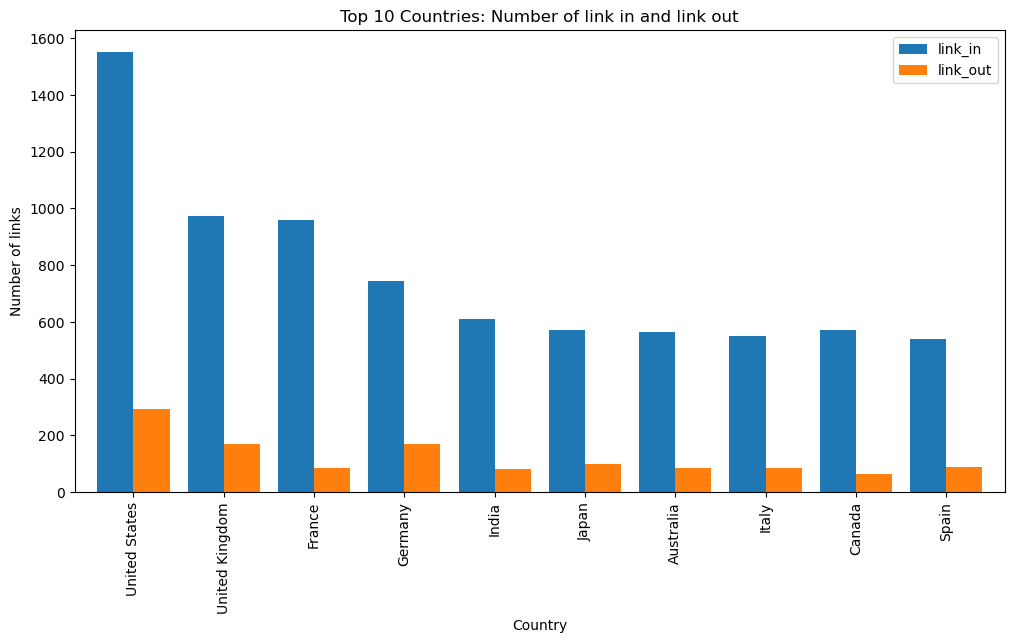

In [19]:
grouped_data = country_links_df.groupby('Country')[['link_in', 'link_out']].sum()
grouped_data['total_links'] = grouped_data['link_in'] + grouped_data['link_out']
grouped_data = grouped_data.sort_values(by='total_links', ascending=False)
top_10_countries = grouped_data.head(10)

fig, ax = plt.subplots(figsize=(12, 6))
top_10_countries[['link_in', 'link_out']].plot(kind='bar', ax=ax, width=0.8)
plt.xlabel('Country')
plt.ylabel('Number of links')
plt.title('Top 10 Countries: Number of link in and link out')
plt.show()

The United States is clearly a hub for it has the most links linking towards him, followed by the United Kingdom and France. It also interesting to notice the difference between the number of links in and out, in average country articles have much more links coming in than out. 

We continue the analysis by looking at the regions and economic classification.

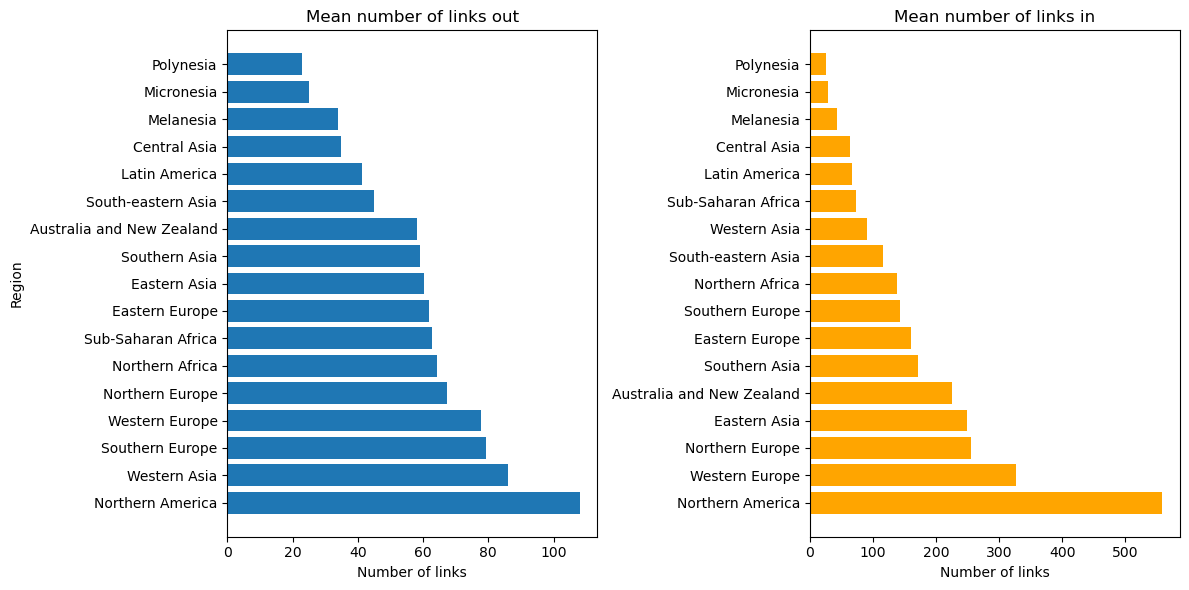

In [20]:
link_out_summary = pd.DataFrame()
link_in_summary = pd.DataFrame()

# Getting summary statistics for each region for in- and out- degrees by region
links_means = country_links_df[['link_out','link_in','Region']].groupby(['Region']).mean()
links_std = country_links_df[['link_out','link_in','Region']].groupby(['Region']).std()
links_max = country_links_df[['link_out','link_in','Region']].groupby(['Region']).max()
links_median = country_links_df[['link_out','link_in','Region']].groupby(['Region']).median()

for df, kind in [(links_means, 'mean'), (links_median, 'median'), (links_std, "std"), (links_max, 'max')]:
    link_out_summary[kind] = df['link_out']
    link_in_summary[kind] = df['link_in']

link_out_summary_df = (link_out_summary.reset_index()).sort_values(by='mean', ascending=False)
link_in_summary_df = (link_in_summary.reset_index()).sort_values(by='mean', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.barh(link_out_summary_df['Region'], link_out_summary_df['mean'])
ax1.set_ylabel('Region')
ax1.set_xlabel('Number of links')
ax1.set_title('Mean number of links out')

ax2.barh(link_in_summary_df['Region'], link_in_summary_df['mean'], color='orange')
ax2.set_xlabel('Number of links')
ax2.set_title('Mean number of links in')
plt.tight_layout()
plt.show()

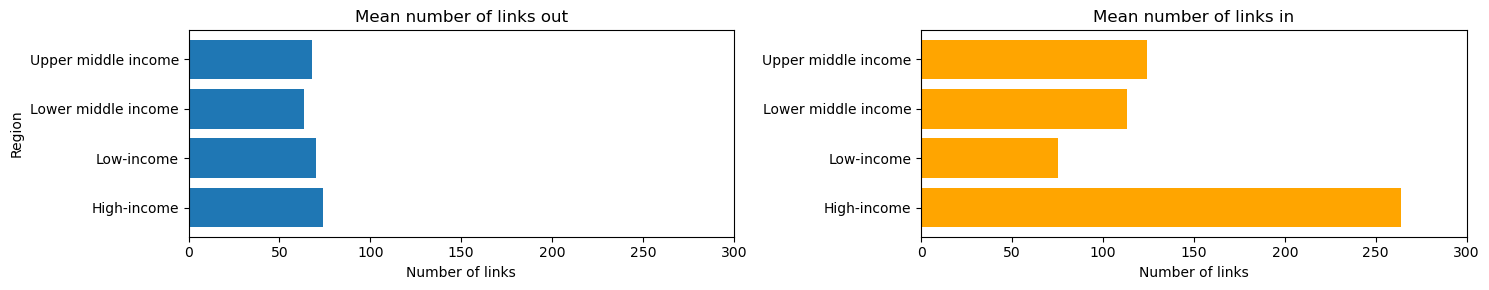

In [21]:
merged_df = country_links_df.merge(UN_countries_by_economies, how='left', on='Country')
merged_df = merged_df[['link_out', 'link_in','Economic classification']]
grouped_df = (merged_df.groupby('Economic classification').mean()).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
ax1.barh(grouped_df['Economic classification'], grouped_df['link_out'])
ax1.set_xlabel('Number of links')
ax1.set_xlim([0, 300])
ax1.set_ylabel('Region')
ax1.set_title('Mean number of links out')

ax2.barh(grouped_df['Economic classification'], grouped_df['link_in'], color='orange')
ax2.set_xlabel('Number of links')
ax2.set_xlim([0, 300])
ax2.set_title('Mean number of links in')
plt.tight_layout()
plt.show()

While the number of links out is similiar (consistence, because also the mean article length is similiar), the differences in number of links in (other articles pointing to country articles) is big.

### 1.4. Sentiment Analysis

Wikipedia aims to keep a neural point of view (NPOV) across all of its articles. In order to test this claim across the articles describing countries, we run a sentiment analysis model across each article. Rankings are given between -1 and 1, with -1 being certainly negative and 1 being certainly positive. The result of the analysis were loaded at the begining of the notebook.

In [22]:
sentiment_analysis_of_countries['Sentiment'].value_counts()

Sentiment
NEU    220
Name: count, dtype: int64

The sentiment of the majority of paragraphs in an article is neutral for all country articles. The 'NEU' is the short code for 'neutral'.
We look at the small disparities there may be between regions and economic classification and if they are relevant.

In [23]:
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, country_region_df, how='left', on='Country')[['sentiment score', 'Region']].groupby('Region').mean()).reset_index()

sa_to_plot['Last Word to sort on'] = sa_to_plot['Region'].str.split().str[-1]
sa_to_plot = sa_to_plot.sort_values(by='Last Word to sort on')
sa_to_plot.drop('Last Word to sort on', axis=1, inplace=True)

sa_region_std_dev = (pd.merge(sentiment_analysis_of_countries, country_region_df, how='left', on='Country')
                     [['sentiment score', 'Region']].groupby('Region')['sentiment score'].std()).reset_index()
sa_economic_std_dev = (pd.merge(sentiment_analysis_of_countries, UN_countries_by_economies, how='left', left_on='Country', right_on='Country')
                       [['sentiment score', 'Economic classification']].groupby('Economic classification')['sentiment score'].std()).reset_index()


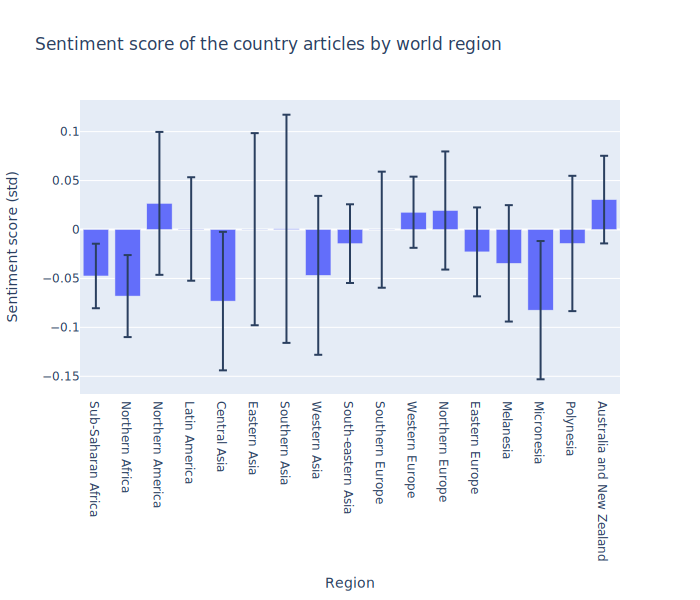

In [24]:
fig = px.bar(sa_to_plot,x='Region', y='sentiment score', error_y=sa_region_std_dev['sentiment score'],
            height =600, labels={'sentiment score':'Sentiment score (std)'}, title='Sentiment score of the country articles by world region')
fig.show('svg')

The error bars represent the standard deviation. Even if we can notice a disparity between the different values, since most of the error bars overlap it is not that relevant. Comparison can only be valuable for a few regions.

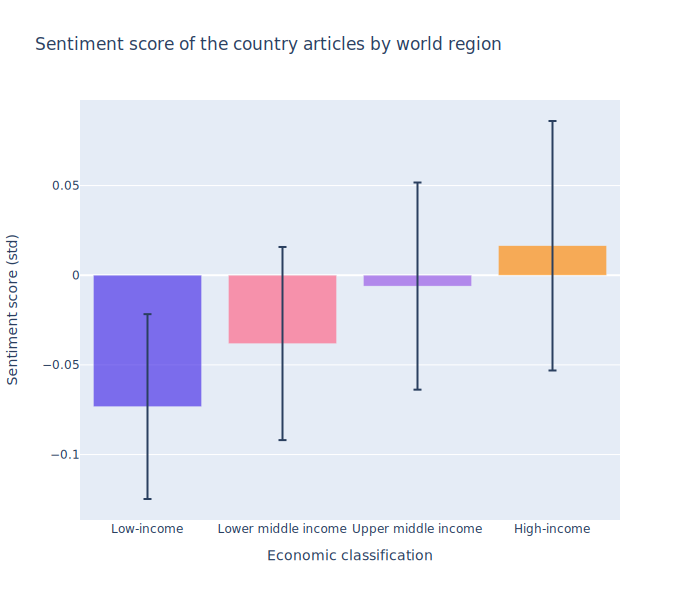

In [25]:
sa_to_plot = (pd.merge(sentiment_analysis_of_countries, UN_countries_by_economies, how='left', left_on='Country', right_on='Country')[['sentiment score', 'Economic classification']].groupby('Economic classification').mean()).reset_index()
sa_to_plot['Economic order'] = sa_to_plot['Economic classification'].map(economic_classification_order)

fig = px.bar(sa_to_plot.sort_values(by='Economic order'),x='Economic classification', y='sentiment score', error_y=sa_economic_std_dev['sentiment score'],
            height =600, labels={'sentiment score':'Sentiment score (std)'}, title='Sentiment score of the country articles by world region',
            color='Economic classification', color_discrete_map=color_scheme, opacity=0.65)
fig. update_layout(showlegend=False)
fig.write_html("plots/sentiment_economic_std.html")
fig.show('svg')


Here again the error bars represented the standard deviation.

### 1.5. Population size

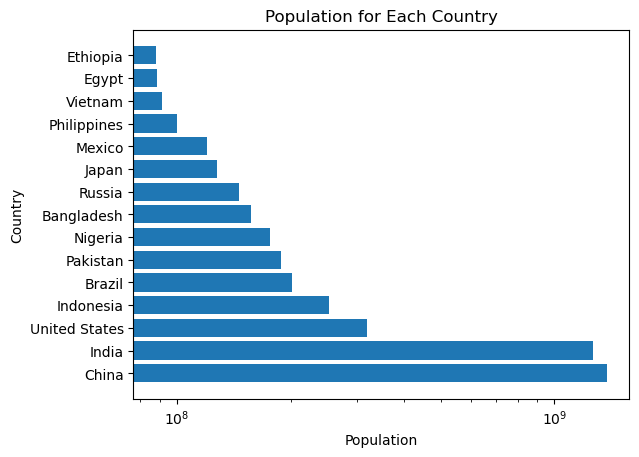

In [26]:
sorted_pop = UN_countries_by_population.sort_values(by='Value', ascending=False)
sorted_pop = sorted_pop.merge(country_region_df, how = 'left', on = 'Country')
sorted_pop = sorted_pop.merge(UN_countries_by_economies, how = 'left', on = 'Country')
sorted_pop = sorted_pop.merge(plaintext_articles, how = 'left', on = 'Country')
sorted_pop = sorted_pop.merge(country_links_df, how = 'left', on = 'Country')
sorted_pop.columns = ['Country', 'Year', 'Value', 'Region', 'LDC', 'LLDC', 'SIDS',
       'Economic_classification', 'Article_content', 'Article_length',
       'link_out', 'link_in', 'Region_y']
sorted_pop = sorted_pop[['Country', 'Value', 'Region','Economic_classification', 'Article_length', 'link_out', 'link_in']] 

top_15_countries = pd.DataFrame(sorted_pop.head(15))

plt.barh(top_15_countries['Country'], top_15_countries['Value'])
plt.ylabel('Country')
plt.xlabel('Population')
plt.title('Population for Each Country')
plt.xscale('log')
plt.show()

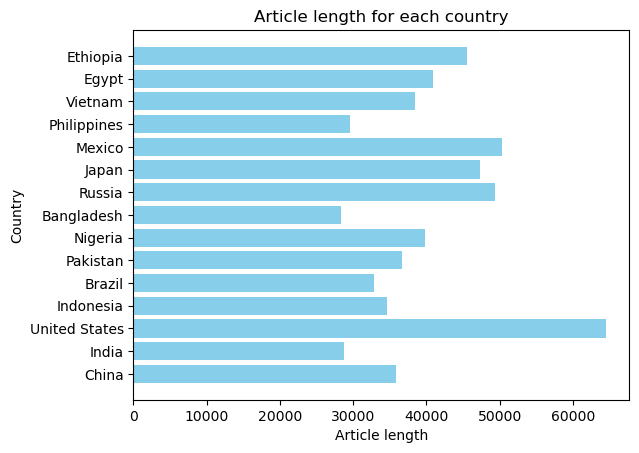

In [27]:
plt.barh(top_15_countries['Country'], top_15_countries['Article_length'], color='skyblue')
plt.ylabel('Country')
plt.xlabel('Article length')
plt.title('Article length for each country')
plt.show()

The goal of the next plot is to show the population in Millions side by side with the article lengths in 100 and the number of links (in and out).

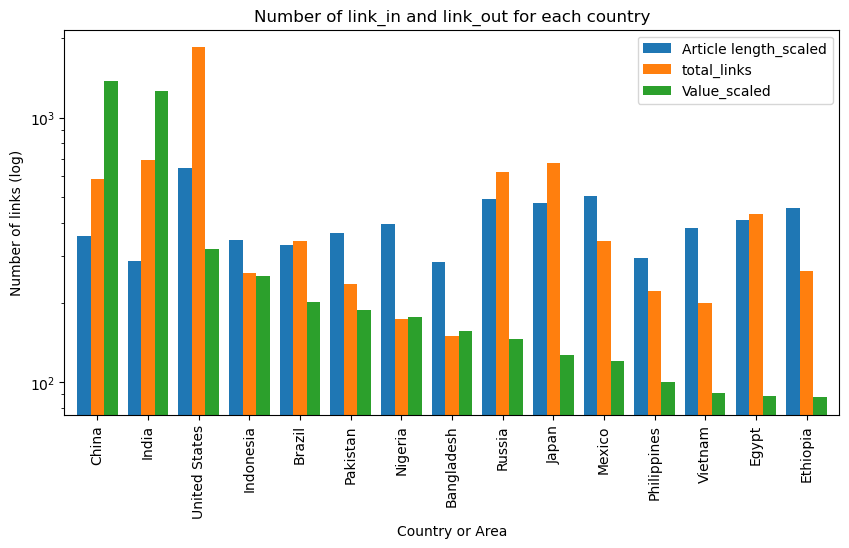

In [28]:
top_15_countries_for_plot = top_15_countries.copy()
top_15_countries_for_plot['total_links'] = top_15_countries_for_plot.apply(
    lambda row: row.link_out + row.link_in, axis = 1
)
top_15_countries_for_plot['Value_scaled'] = top_15_countries_for_plot.apply(
    lambda row: row.Value / 1000000, axis = 1 #### scaling factor chan be changed
)
top_15_countries_for_plot['Article length_scaled'] = top_15_countries_for_plot.apply(
    lambda row: row.Article_length / 100, axis = 1 #### scaling factor chan be changed
)
top_15_countries_for_plot.set_index('Country', inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))

top_15_countries_for_plot[['Article length_scaled', 'total_links', 'Value_scaled']].plot(kind='bar', ax=ax, width=0.8)
xticks = ['']
plt.xlabel('Country or Area')
plt.ylabel('Number of links (log)')
plt.yscale('log')
plt.title('Number of link_in and link_out for each country')
plt.legend()

plt.show()

## Part 2:

Descriptive statistics and naive statistical analysis about the behaviour of the players

1. Ratio of finished pathways, where articles* are the target (includes the creation of two helper dataframes, region_paths_df and econ_paths_df)
2. Length of the pathway taken respectively the time needed, where articles* are the target
3. How often does an article* appear in a pathway where it is neither the start nor the traget?

### 2.1. Ratio of finished pathways

Next, we analyse the paths taken by the users and inspect the number of finished pathways vs the unfinished ones.

In [29]:
region_completed_count = country_path_overview[['Region','completed','target']].groupby(['Region','completed']).count()
region_count = country_path_overview[['Region','target']].groupby(['Region']).count()

region_paths_df = pd.DataFrame(columns = ['Region', 'Status', 'Proportion'])
index = 0
for region, completion in region_completed_count.index:
    proportion = region_completed_count.loc[(region, completion)] / region_count.loc[region]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    new_row = {'Region': region, 'Status': status, 'Proportion': round(proportion.values[0]*100,1)}
    region_paths_df.loc[index] = new_row
    index += 1

region_paths_df.head()

,Region,Status,Proportion
0,Australia and New Zealand,unfinished,19.0
1,Australia and New Zealand,finished,81.0
2,Central Asia,unfinished,18.1
3,Central Asia,finished,81.9
4,Eastern Asia,unfinished,7.9


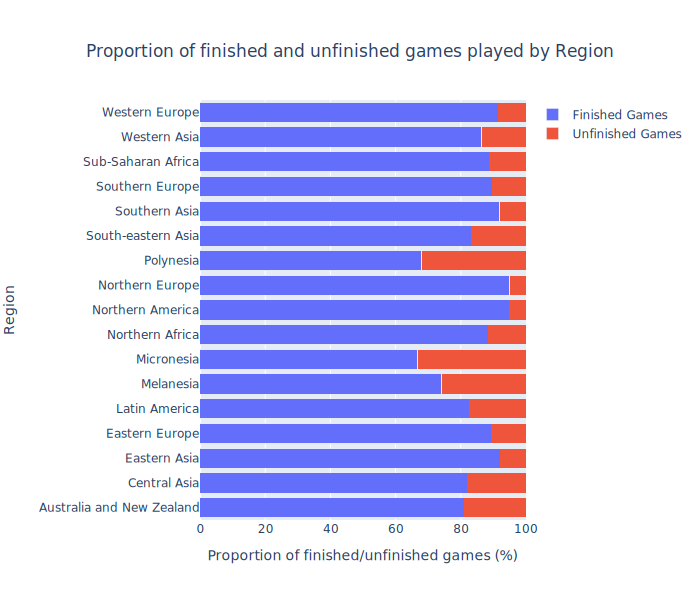

In [30]:
labels = region_paths_df['Region'].unique()
finished_means = region_paths_df[region_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = region_paths_df[region_paths_df['Status'] == 'unfinished']['Proportion']

region_paths_df_updated = pd.DataFrame({
    'Region': labels,
    'Finished Games': finished_means.values,
    'Unfinished Games': unfinished_means.values
})

fig = px.bar(region_paths_df_updated, y='Region', x=['Finished Games', 'Unfinished Games'], orientation='h', barmode='stack',
             labels={'Values1': 'Trace 1', 'Values2': 'Trace 2'},
             title='Stacked Horizontal Bar Chart')

fig.update_layout(
    xaxis=dict(range=[0, 100]),
    height = 600,
    title='Proportion of finished and unfinished games played by Region', 
    xaxis_title='Proportion of finished/unfinished games (%)',
    yaxis_title='Region',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = ""
)

fig.show('svg')


In [31]:
econ_completed_count = country_path_overview[['Economic classification','completed','target']].groupby(['Economic classification','completed']).count()
econ_count = country_path_overview[['Economic classification','target']].groupby(['Economic classification']).count()

econ_paths_df = pd.DataFrame(columns = ['Economic classification', 'Status', 'Proportion'])
index = 0
for econ, completion in econ_completed_count.index:
    proportion = econ_completed_count.loc[(econ, completion)] / econ_count.loc[econ]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    # print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")
    new_row = {'Economic classification': econ, 'Status': status, 'Proportion': round(proportion.values[0]*100,1)}
    econ_paths_df.loc[index] = new_row
    index += 1

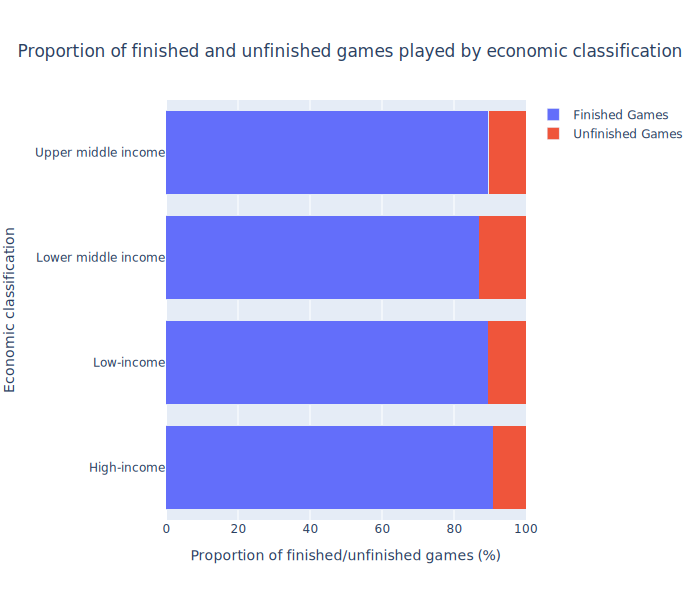

In [32]:
labels = econ_paths_df['Economic classification'].unique()
finished_means = econ_paths_df[econ_paths_df['Status'] == 'finished']['Proportion']
unfinished_means = econ_paths_df[econ_paths_df['Status'] == 'unfinished']['Proportion']

region_paths_df_updated = pd.DataFrame({
    'Economic classification': labels,
    'Finished Games': finished_means.values,
    'Unfinished Games': unfinished_means.values})

fig = px.bar(region_paths_df_updated, y='Economic classification', x=['Finished Games', 'Unfinished Games'], orientation='h', barmode='stack',
             labels={'Values1': 'Trace 1', 'Values2': 'Trace 2'},
             title='Stacked Horizontal Bar Chart')

fig.update_layout(
    xaxis=dict(range=[0, 100]),
    height = 600,
    title='Proportion of finished and unfinished games played by economic classification', 
    xaxis_title='Proportion of finished/unfinished games (%)',
    yaxis_title='Economic classification',
    title_x = 0.5,
    title_y = 0.925,
    legend_title_text = "")

fig.show('svg')

### 2.2. Length and time needed

For the analysis of the length of the pathways and the time needed by the player we create a helper dataframes of the finished pathways only and group them by Region resp. Economic classification and shortest paths.


In [33]:
regions_paths = country_path_overview[['Region','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['Region','shortest_distance']).median().reset_index()
econ_paths = country_path_overview[['Economic classification','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['Economic classification','shortest_distance']).median().reset_index()

regions_paths_1 = regions_paths[regions_paths['shortest_distance'] == 1]
regions_paths_2 = regions_paths[regions_paths['shortest_distance'] == 2]
regions_paths_3 = regions_paths[regions_paths['shortest_distance'] == 3]
regions_paths_4 = regions_paths[regions_paths['shortest_distance'] == 4]

econ_paths_1 = econ_paths[econ_paths['shortest_distance'] == 1]
econ_paths_2 = econ_paths[econ_paths['shortest_distance'] == 2]
econ_paths_3 = econ_paths[econ_paths['shortest_distance'] == 3]
econ_paths_4 = econ_paths[econ_paths['shortest_distance'] == 4]

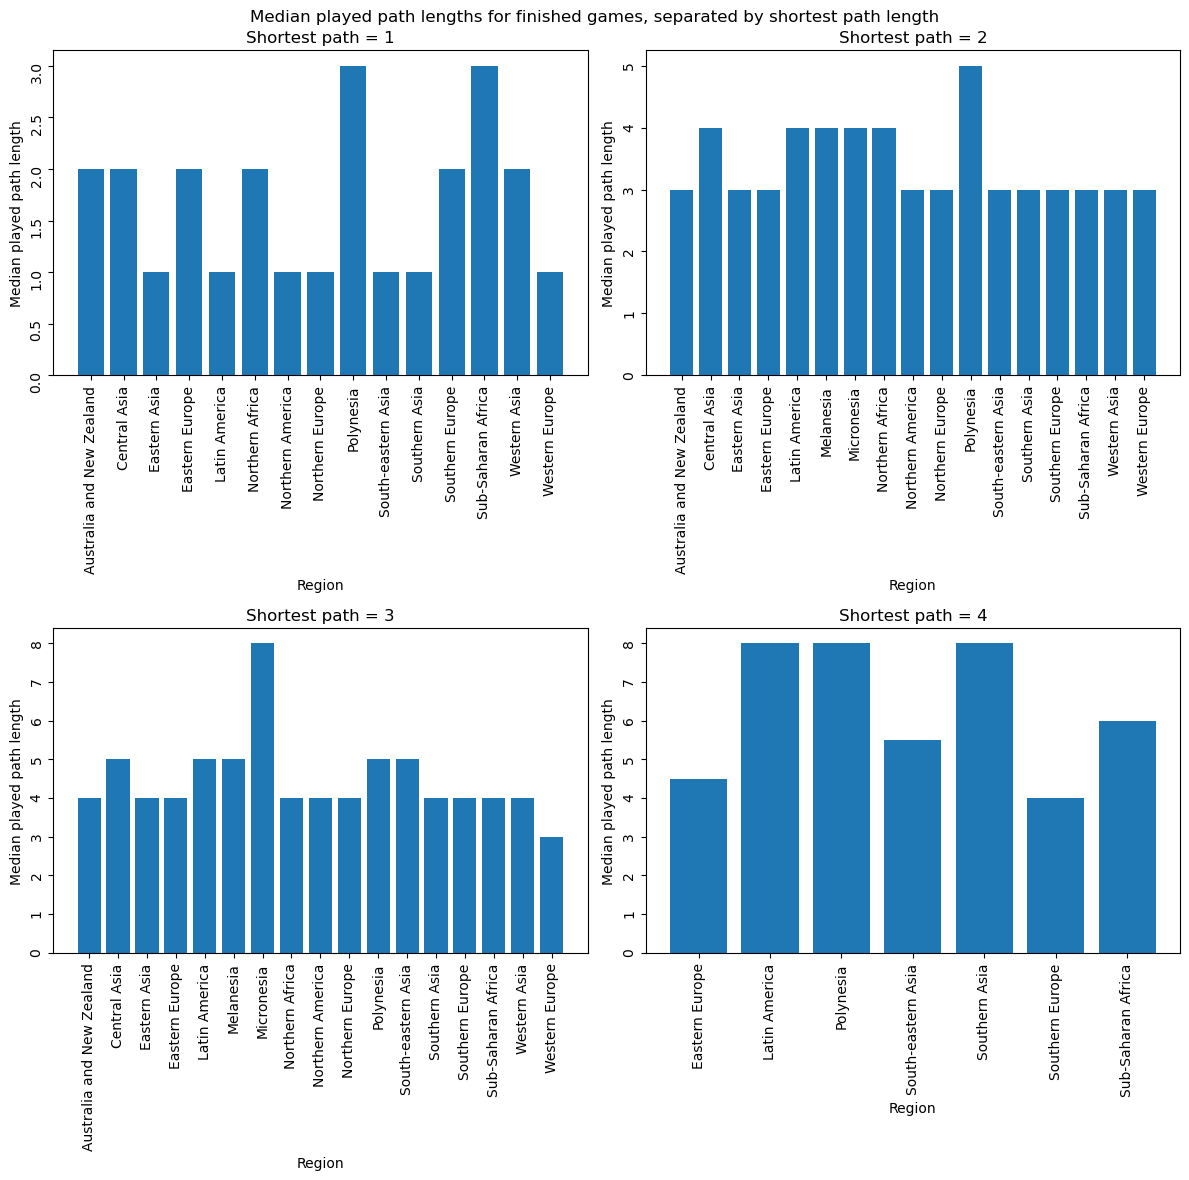

In [34]:
figs, axs = plt.subplots(2,2, figsize=(12,12))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(regions_paths_1['Region'], regions_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Region")
axs[0,0].set_ylabel("Median played path length")
axs[0,0].tick_params(labelrotation=90)

axs[0,1].bar(regions_paths_2['Region'], regions_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Region")
axs[0,1].set_ylabel("Median played path length")
axs[0,1].tick_params(labelrotation=90)

axs[1,0].bar(regions_paths_3['Region'], regions_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Region")
axs[1,0].set_ylabel("Median played path length")
axs[1,0].tick_params(labelrotation=90)

axs[1,1].bar(regions_paths_4['Region'], regions_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Region")
axs[1,1].set_ylabel("Median played path length")
axs[1,1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

# For shortest path = 4 some regions don't have a value, because all their targets have a shortest length of max. 3

For shortest path = 4 some regions don't have a value, because all their targets have a shortest length of max. 3.

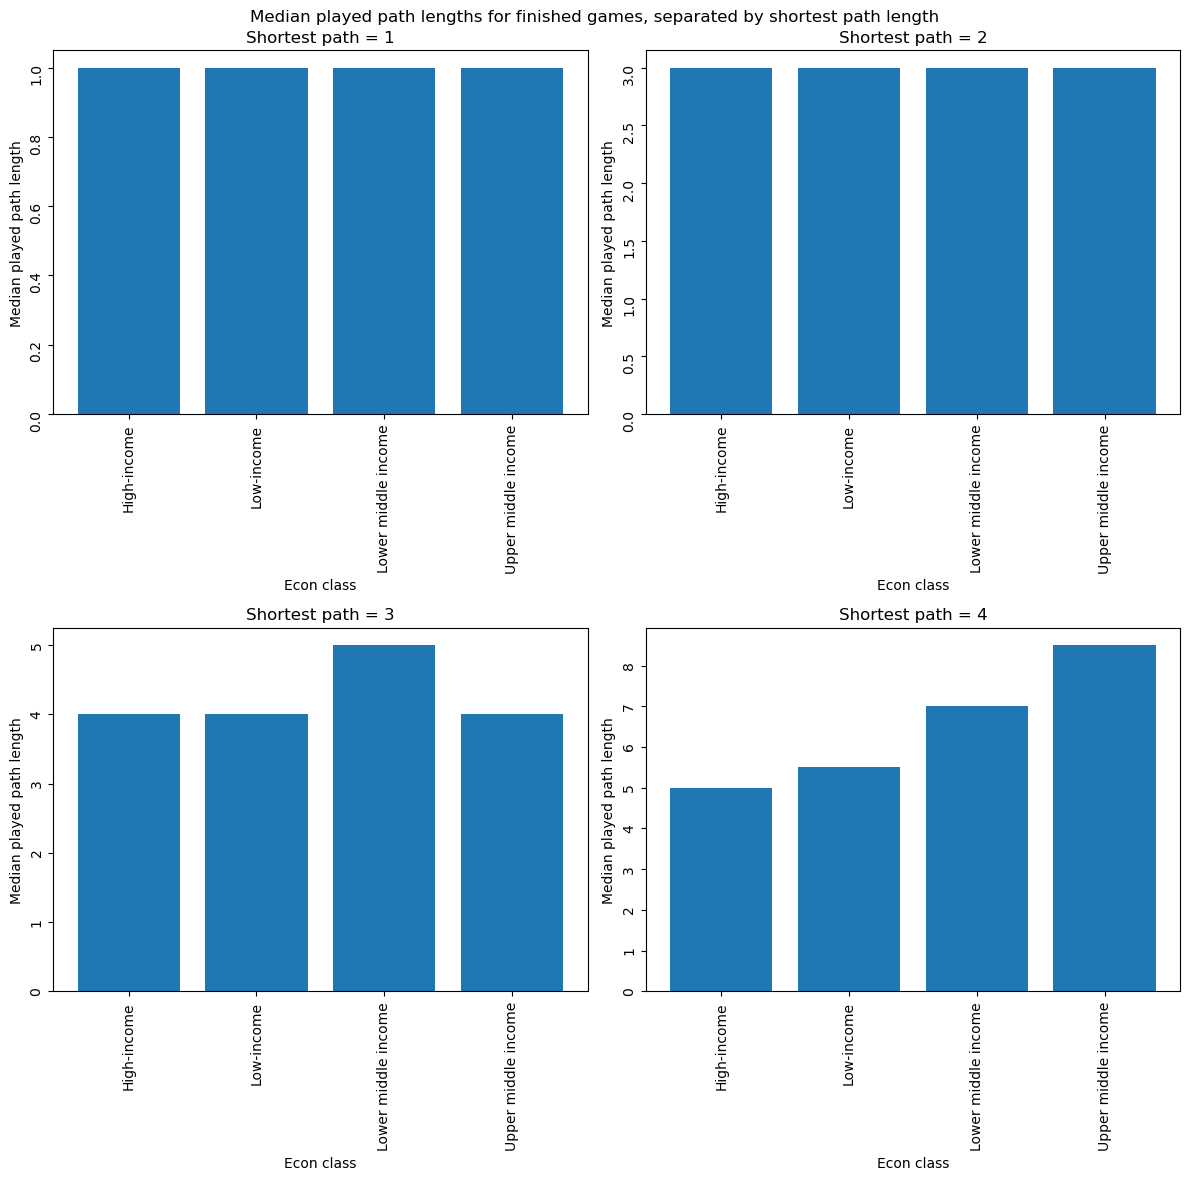

In [35]:
figs, axs = plt.subplots(2,2, figsize=(12,12))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(econ_paths_1['Economic classification'], econ_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Econ class")
axs[0,0].set_ylabel("Median played path length")
axs[0,0].tick_params(labelrotation=90)

axs[0,1].bar(econ_paths_2['Economic classification'], econ_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Econ class")
axs[0,1].set_ylabel("Median played path length")
axs[0,1].tick_params(labelrotation=90)

axs[1,0].bar(econ_paths_3['Economic classification'], econ_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Econ class")
axs[1,0].set_ylabel("Median played path length")
axs[1,0].tick_params(labelrotation=90)

axs[1,1].bar(econ_paths_4['Economic classification'], econ_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Econ class")
axs[1,1].set_ylabel("Median played path length")
axs[1,1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

### 2.3. Frequency of article C's involvement in pathways where it was neither the start nor the target
We create a similar dataframe than paths_finished in the data wrangling part, but add the whole paths. We expand the finished and unfinished paths

In [36]:
# expand the finished paths
paths_finished_task3 = paths_finished_load.copy()
path_fin_task3 = paths_finished_task3.assign(source=paths_finished_task3['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                           target=paths_finished_task3['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                           game_path=paths_finished_task3['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                           completed=True,
                           paths=paths_finished_task3['path'])

# expand the unfinished paths
paths_unfinished_task3 = paths_unfinished_load.copy()
path_unfin_task3 = paths_unfinished_task3.assign(source=paths_unfinished_task3['path'].apply(lambda x: hlp.seperate_path(x)[0]),
                             failure_article=paths_unfinished_task3['path'].apply(lambda x: hlp.seperate_path(x)[1]),
                             game_path=paths_unfinished_task3['path'].apply(lambda x: hlp.seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished_task3["target"],
                             paths=paths_unfinished_task3['path'])

# construct a new dataframe: path_overview_task3
path_overview_task3 = pd.concat([path_fin_task3, path_unfin_task3], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                                        "durationInSec", "game_path","completed", "rating", "type", "paths"]]

# United_States -> United States (IMPORTANT: Don't do it here)

# Split "paths" in path_overview2
path_overview_task3['paths'] = path_overview_task3['paths'].str.replace(';',' ')
display(path_overview_task3)

,source,target,hashedIpAddress,timestamp,durationInSec,game_path,completed,rating,type,paths
0,14th_century,African_slave_trade,6a3701d319fc3754,1297740409,166,8,True,NaN,NaN,14th_century 15th_century 16th_century Pacific...
1,14th_century,African_slave_trade,3824310e536af032,1344753412,88,4,True,3.0,NaN,14th_century Europe Africa Atlantic_slave_trad...
2,14th_century,African_slave_trade,415612e93584d30e,1349298640,138,7,True,NaN,NaN,14th_century Niger Nigeria British_Empire Slav...
3,14th_century,Greece,64dd5cd342e3780c,1265613925,37,3,True,NaN,NaN,14th_century Renaissance Ancient_Greece Greece
4,14th_century,John_F._Kennedy,015245d773376aab,1366730828,175,6,True,3.0,NaN,14th_century Italy Roman_Catholic_Church HIV R...
...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,109ed71f571d86e9,1389787605,180,7,False,NaN,restart,Franz_Kafka Tuberculosis World_Health_Organiza...
76189,Modern_history,Hollandic,232f992e57d43e8d,1389787697,6,0,False,NaN,restart,Modern_history
76190,Computer_programming,The_Beatles,2e09a7224600a7cd,1389798400,1900,4,False,NaN,timeout,Computer_programming Linguistics Culture Popul...
76191,Jamaica,Alan_Turing,60af9e2138051b96,1389799481,1903,3,False,NaN,timeout,Jamaica United_Kingdom World_War_II Battle_of_...


In [37]:
# Count frequecy where article C is in a path (but is not start/target)
country_counts = {}

# Get list of all countries to iterate through
countries = plaintext_articles['Country'].str.replace(" ", "_")

for _, row in path_overview_task3.iterrows():
    articles = row['paths'].split()
    for country in countries:
        # check it is not target
        if country in articles and country != row['source'] and country != row['target']:
            # Count occurrences of the country in the paths
            count = articles.count(country)

            # update dict
            country_counts.setdefault(country, 0)
            country_counts[country] += count

# Create Dataframe and rename: United_States -> United States (important before merging) and
# add Region and Economic classification information
country_counts_df = pd.DataFrame(list(country_counts.items()), columns=['Country', 'Count'])
country_counts_df['Country'] = country_counts_df['Country'].str.replace('_',' ')
country_counts_df = country_counts_df.sort_values(by='Count', ascending=False)
country_counts_df = country_counts_df.merge(country_region_df, on = 'Country', how = 'left')
country_counts_df = country_counts_df.merge(UN_countries_by_economies[['Country', 'Economic classification']], on = 'Country', how = 'left')
display(country_counts_df)

,Country,Count,Region,Economic classification
0,United States,12366,Northern America,High-income
1,United Kingdom,5278,Northern Europe,High-income
2,France,2201,Western Europe,High-income
3,Germany,2121,Western Europe,High-income
4,India,1722,Southern Asia,Lower middle income
...,...,...,...,...
213,Kosovo,2,Eastern Europe,NaN
214,Serbia and Montenegro,1,Southern Europe,Upper middle income
215,South Ossetia,1,Western Asia,NaN
216,Turkish Republic of Northern Cyprus,1,Southern Europe,NaN


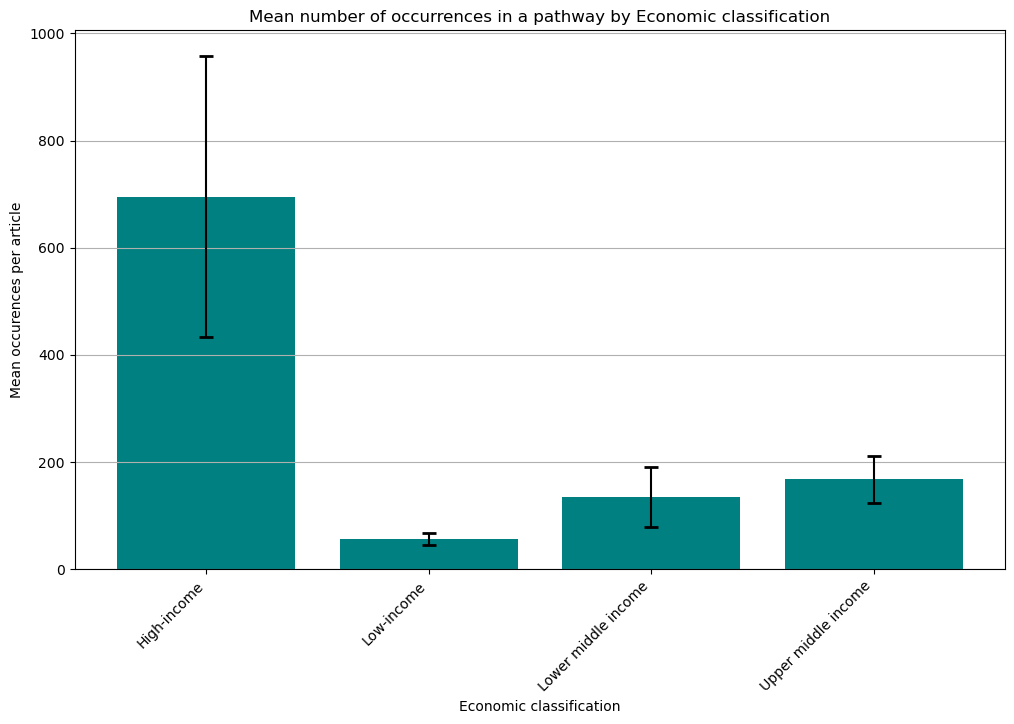

In [38]:
cc_to_plot = country_counts_df[['Count', 'Economic classification']].groupby('Economic classification').mean().reset_index()
cc_std = country_counts_df[['Count', 'Economic classification']].groupby('Economic classification').std().reset_index()
cc_counts = country_counts_df[['Count', 'Economic classification']].groupby('Economic classification').count().reset_index()
cc_se = cc_std['Count'].values/np.sqrt(cc_counts['Count'].values)
# Plot
plt.figure(figsize=(12, 7))
plt.bar(cc_to_plot['Economic classification'], cc_to_plot['Count'], color='teal')
plt.title('Mean number of occurrences in a pathway by Economic classification')
plt.xlabel('Economic classification')
plt.ylabel('Mean occurences per article')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.errorbar(cc_to_plot['Economic classification'], cc_to_plot['Count'], yerr=cc_se, fmt='none', ecolor='black', capsize=5, capthick=2)
plt.show()

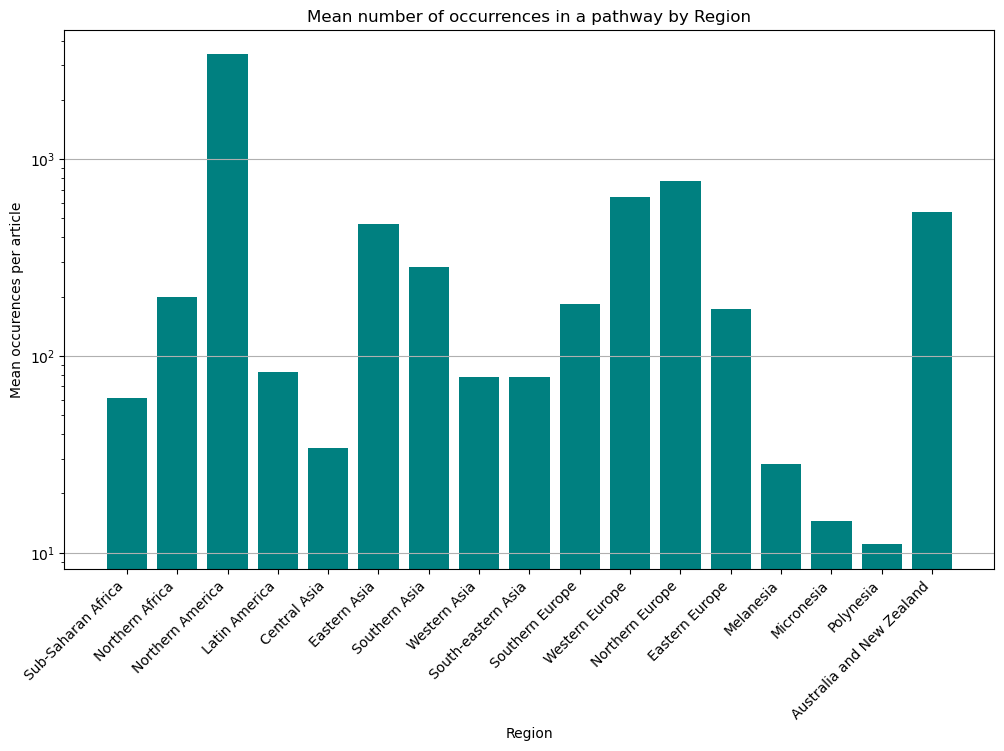

In [39]:
cc_to_plot = country_counts_df[['Count', 'Region']].groupby('Region').mean().reset_index()

cc_to_plot['Last Word to sort on'] = cc_to_plot['Region'].str.split().str[-1]
cc_to_plot = cc_to_plot.sort_values(by='Last Word to sort on')
cc_to_plot.drop('Last Word to sort on', axis=1, inplace=True)

# Plot
plt.figure(figsize=(12, 7))
plt.bar(cc_to_plot['Region'], cc_to_plot['Count'], color='teal')
plt.title('Mean number of occurrences in a pathway by Region')
plt.xlabel('Region')
plt.ylabel('Mean occurences per article')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.yscale("log")
plt.show()

## Part 3

To check for potential bias through regression analysis, we will focus on two types of bias: game bias and player bias.

- Game Bias: Inherent bias in the game structure (Article Lengths, number of links, sentiment score in articles, avg shortest distance  in games)

- Player Bias: Bias in player behaviour independent to game structure. (Finished vs Unfinished games, Avg_game_length)

### 3.1. Pre-process data for regression analysis
We first create a main df to put all independent and dependent variables together.

In [40]:
# Start with the country links df
main_df = country_links_df.copy()

# Sort and reset the index for clean data
UN_countries_by_population = UN_countries_by_population.sort_values('Country').reset_index(drop=True)

# Now, we can perform your merge operation as before
main_df = pd.merge(main_df, UN_countries_by_population[['Country', 'Value']], on='Country', how='left')
main_df.rename(columns={'Value': 'Population'}, inplace=True)

main_df = main_df.merge(UN_countries_by_economies[['Country', 'Economic classification']], on='Country', how='left')
main_df = main_df.merge(plaintext_articles[['Country', 'Article length']], on='Country', how='left')
main_df = main_df.merge(sentiment_analysis_of_countries[['Country', 'sentiment score']], on='Country', how='left')

#Using coutnry path overview to aggregate paths per country
# Renaming 'target' to 'Country'
country_path_overview.rename(columns={'target': 'Country'}, inplace=True)

# Ensure no null values in 'completed' column
country_path_overview['completed'].fillna(False, inplace=True)

# Calculating 'Finished' and 'Unfinished' counts
country_path_overview['Finished'] = country_path_overview['completed'].apply(lambda x: 1 if x else 0)
country_path_overview['Unfinished'] = country_path_overview['completed'].apply(lambda x: 0 if x else 1)

# Group by 'Country' and calculate avgs
country_path_avg = country_path_overview.groupby('Country').agg(
    Finished=('Finished', 'sum'),
    Unfinished=('Unfinished', 'sum'),
    Avg_Shortest_Distance=('shortest_distance', 'mean'),
    Avg_Game_Path_Length=('game_path', 'mean')
).reset_index()

 #Add the new columns to the main df
main_df = main_df.merge(country_path_avg, on='Country', how='left')

# Display the merged dataframe to verify the changes
display(main_df)

,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774
1,Lebanon,192.0,114.0,Western Asia,NaN,Upper middle income,50131.0,-0.107762,15.0,2.0,1.882353,3.823529
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000
3,Georgia (country),180.0,84.0,Western Asia,3.713804e+06,Lower middle income,NaN,NaN,4.0,1.0,2.200000,2.800000
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957
...,...,...,...,...,...,...,...,...,...,...,...,...
214,Anguilla,14.0,19.0,Latin America,1.422123e+04,NaN,6989.0,0.137700,5.0,4.0,2.666667,9.888889
215,Turkish Republic of Northern Cyprus,12.0,22.0,Southern Europe,NaN,NaN,19614.0,-0.107449,11.0,2.0,2.692308,3.769231
216,Saint Kitts and Nevis,12.0,26.0,Latin America,NaN,NaN,7436.0,-0.050647,0.0,3.0,2.333333,4.000000
217,Serbia and Montenegro,11.0,6.0,Southern Europe,7.146759e+06,Upper middle income,11975.0,-0.051043,17.0,4.0,3.142857,5.285714


#### Cleaning data before modeling
We count NaNs in each column and display it. We then filter them out. 


In [41]:
nan_counts = main_df.isna().sum()
print(nan_counts)
countries_with_nan_population = main_df[main_df['Population'].isna()]
print(countries_with_nan_population['Country'])

Country                     0
link_out                    0
link_in                     2
Region                      0
Population                 26
Economic classification    60
Article length              6
sentiment score             6
Finished                    3
Unfinished                  3
Avg_Shortest_Distance       3
Avg_Game_Path_Length        3
dtype: int64
1                                  Lebanon
23                                  Serbia
58                               Hong Kong
62                                   Syria
79          British Indian Ocean Territory
101                                 Kosovo
103                       Falkland Islands
131                      Equatorial Guinea
136               Central African Republic
137                       Christmas Island
140                         Western Sahara
146                                 Taiwan
149                           Vatican City
150                            North Korea
155                      

We drop rows with NaN values, and filter the df to find rows where 'Population' is NaN.

In [42]:
main_df = main_df.dropna()
countries_with_nan_population = main_df[main_df['Population'].isna()]

### 3.2 Understand variable correlation before regression analysis

Before performing the regression analysis, we are doing a quick inspection to understand the relationship between all of our variables.

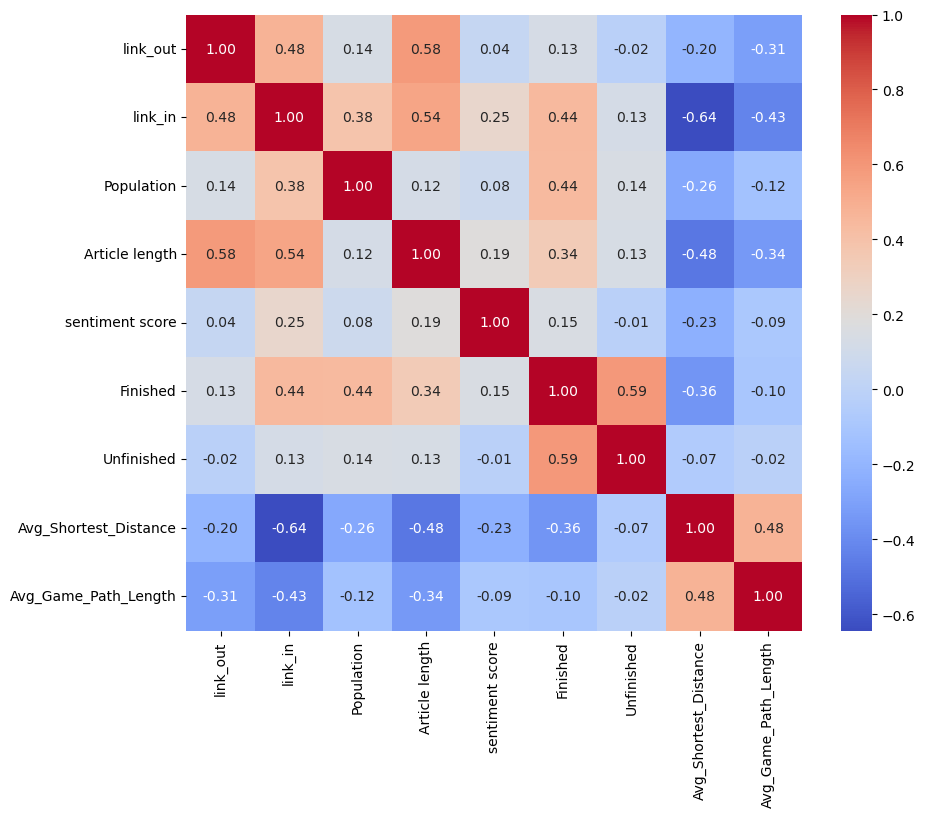

In [43]:
# Select only numeric columns for the correlation matrix
numeric_cols = main_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.show()

Red show high correlation, blue shows low correlation. We can see that article length correlates with link in and link out, which is expected. Population appears not to correlate with article length, this could be because article length come from historical importance or country's influence (maybe economic classificaiton would be a good metric, but it was not shown because it is not currently a numerical variable).

#### Adding economic classification

Here, we add Economic Classification as a numerical variable, so that we can look at correlations with this variable.

In [44]:
# List all unique economic classifications
unique_economic_classes = main_df['Economic classification'].unique()
print(unique_economic_classes)

['High-income' 'Lower middle income' 'Upper middle income' 'Low-income']


In [45]:
economic_class_mapping = {
    'Low-income': 1, 
    'Lower middle income': 2,
    'Upper middle income': 3,
    'High-income': 4
}

# Map the economic classifications to their respective ordinal number
main_df['Economic classification_dummy'] = main_df['Economic classification'].map(economic_class_mapping)

#### Correlation matrix with economic classification

Here, we re-run the above correlations again, and we take into account the economic classification added above.

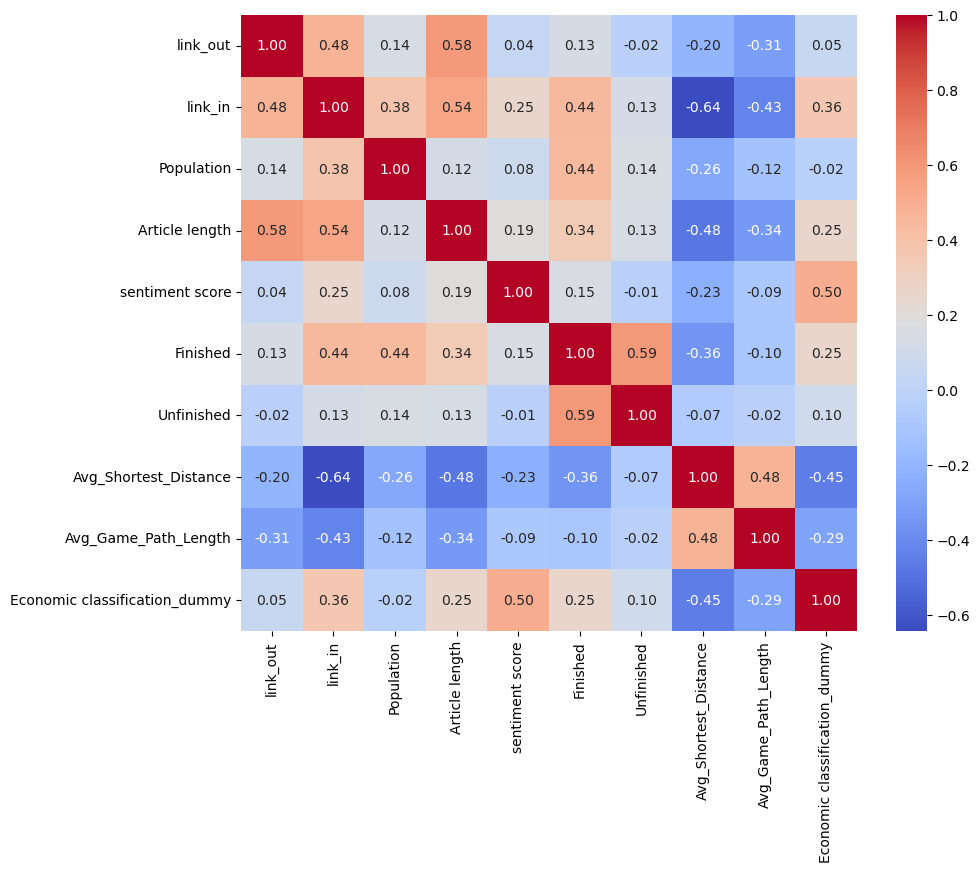

In [46]:
# Select only numeric columns for the correlation matrix
numeric_cols = main_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.show()

- High correlation between shortest avg distance and avg game path, suggesting shorter paths are more likely to be completed.
- High inverse correlation between avg_short_distance and link_in suggesting that games containing target countries that have higher in-degree in are more likely to be completed.
- High correlation between link_in and article length suggesting that longer articles have more links, and therefore from above, are more likely to be completed.
- High correlation between Economic classification and link_in suggesting that higher economic classification results in a higher in-degree, BUT higher economic classification appears not to be correlated with article length.
- High correlation between economic classification and sentiment score suggesting that countries with higher sentiment scores are more likely to be completed.

#### Adding, regions to correlation matrix

We will try to do the same with the regions as we did with the economic classification

In [47]:
# Array of the 17 regions
regions = ['Northern America', 'Western Asia', 'Western Europe', 'Northern Europe', 'Latin America', 
           'Sub-Saharan Africa', 'Eastern Europe', 'Southern Europe', 'Northern Africa', 'Southern Asia', 
           'Eastern Asia', 'Australia and New Zealand', 'South-eastern Asia', 'Melanesia', 'Central Asia',
           'Polynesia', 'Micronesia']

regions_df = pd.DataFrame(regions, columns=['Region'])

# Mapping regions to numbers based on geographical proximity
region_mapping = {
    'Northern America': 1,
    'Latin America': 2,
    'Northern Europe': 3,
    'Western Europe': 4,
    'Southern Europe': 5,
    'Eastern Europe': 6,
    'Northern Africa': 7,
    'Sub-Saharan Africa': 8,
    'Western Asia': 9,
    'Central Asia': 10,
    'Eastern Asia': 11,
    'Southern Asia': 12,
    'South-eastern Asia': 13,
    'Australia and New Zealand': 14,
    'Melanesia': 15,
    'Micronesia': 16,
    'Polynesia': 17
}

# Map the regions to their respective ordinal number and add as a new column
main_df['region_dummy'] = main_df['Region'].map(region_mapping)
display(main_df)

,Country,link_out,link_in,Region,Population,Economic classification,Article length,sentiment score,Finished,Unfinished,Avg_Shortest_Distance,Avg_Game_Path_Length,Economic classification_dummy,region_dummy
0,United States,294.0,1551.0,Northern America,3.188571e+08,High-income,64482.0,0.030681,28.0,3.0,1.612903,2.096774,4,1
2,Armenia,186.0,99.0,Western Asia,3.013839e+06,Lower middle income,45797.0,0.021531,9.0,1.0,2.600000,3.600000,2,9
4,Turkey,172.0,249.0,Western Asia,7.769590e+07,Upper middle income,46426.0,0.003038,21.0,2.0,2.086957,3.086957,3,9
5,Israel,169.0,236.0,Western Asia,8.215668e+06,High-income,66246.0,-0.046935,27.0,3.0,2.433333,3.700000,4,9
6,Germany,169.0,743.0,Western Europe,8.098250e+07,High-income,68951.0,-0.036626,49.0,6.0,1.600000,2.527273,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Liberia,21.0,61.0,Sub-Saharan Africa,3.946311e+06,Low-income,22281.0,-0.121275,15.0,1.0,2.625000,4.687500,1,8
202,Guinea-Bissau,21.0,52.0,Sub-Saharan Africa,1.514451e+06,Low-income,9618.0,-0.092631,7.0,0.0,2.428571,7.142857,1,8
204,Paraguay,20.0,39.0,Latin America,6.657232e+06,Lower middle income,9346.0,-0.028492,27.0,1.0,2.607143,4.642857,2,2
210,United Arab Emirates,18.0,59.0,Western Asia,8.798841e+06,High-income,12581.0,-0.044119,56.0,8.0,2.812500,4.328125,4,9


In [48]:
# Sanity check to ensure there are no NaNs
nan_counts = df.isnull().sum()
nan_count = df.isnull().sum().sum()
if nan_count > 0:
    print(f"The DataFrame contains {nan_count} NaN values.")
else:
    print("The DataFrame does not contain any NaN values.")

The DataFrame does not contain any NaN values.


#### Correlation matrix with region

Here, we re-run the above correlations again, and we take into account the region added above.

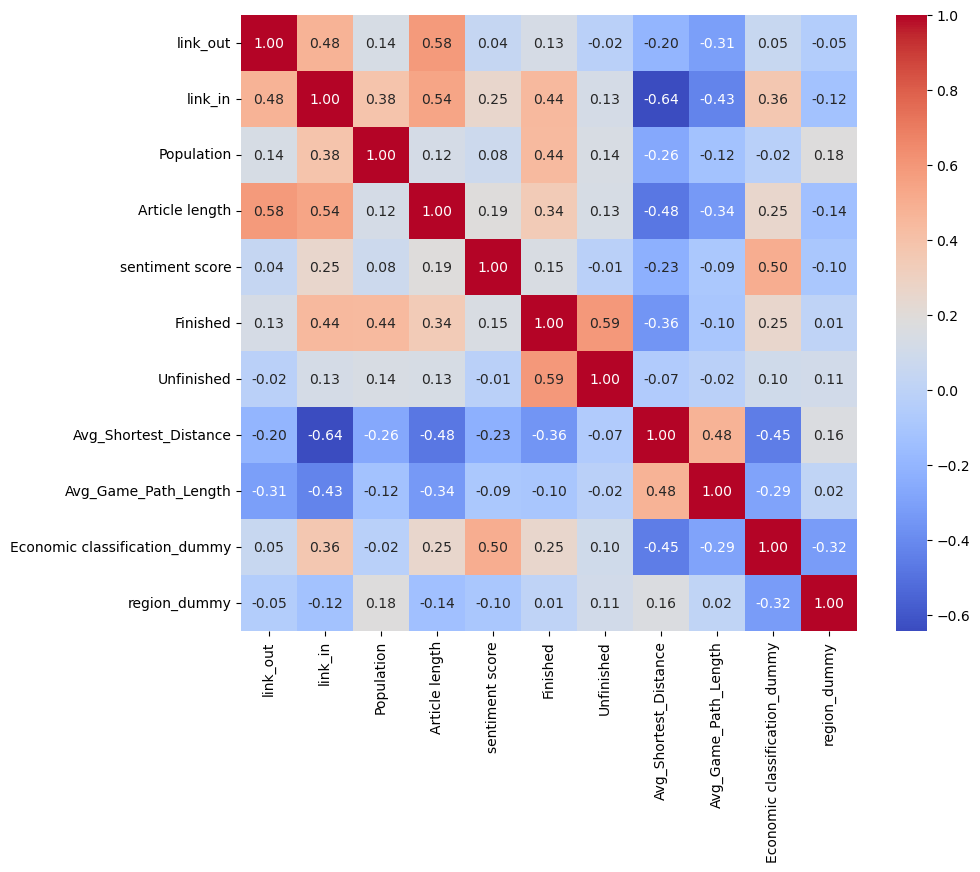

In [49]:
# Select only numeric columns for the correlation matrix
numeric_cols = main_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.show()

From this analysis, there doesn't seem to be any correlation, however translating the region into a dummy variable does not seem to be effective as the cardinality in the numbers is meaningless for regions. We will instead use one-hot encoding for this task.

### 3.3 Game Bias

To check for inherent bias in the game structure, we will use:

**Independent variables:**      Population, Economic classification, Country, Region

**Dependent variables:**        article length, sentiment score, link_in, avg shortest distance (Link_out is not an advantae in the game, so we will exclude this variable and focus on links_in)

**Important:**                  Correlation does not necessarily imply causation.

In [50]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Population', 'Economic classification_dummy', 'region_dummy']]
y = main_df['Article length']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Article length   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     4.661
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00387
Time:                        22:46:18   Log-Likelihood:                -1618.7
No. Observations:                 148   AIC:                             3245.
Df Residuals:                     144   BIC:                             3257.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Article length does not seem to be highly predicted by either region, economic classification or population. Suggesting there is no bias in the length of articles, relating to these variables.

#### Now for links_in with the same independant variables as above:

In [51]:
# Define the predictor variables (X) and the response variable (y)
y = main_df['link_in']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     19.98
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           6.97e-11
Time:                        22:46:18   Log-Likelihood:                -967.91
No. Observations:                 148   AIC:                             1944.
Df Residuals:                     144   BIC:                             1956.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

There seems to be some correlation, however our variables do not seemt o strongly predict the variance for ```links_in```, which is our most important variable to determine success in the game.

#### Now to try each variable separately, to see if there is a specific variable that is causing issues

We ran linear regression and plotted the results for each variable individually, in order to see if there were any strange datapoints, or incorrect analyses.

In [52]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Economic classification_dummy']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     22.38
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           5.23e-06
Time:                        22:46:18   Log-Likelihood:                -983.11
No. Observations:                 148   AIC:                             1970.
Df Residuals:                     146   BIC:                             1976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

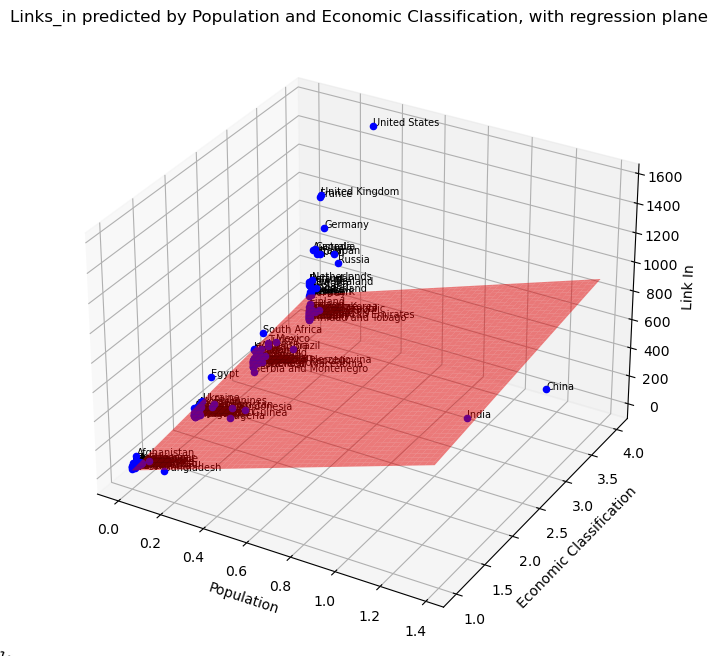

In [53]:
# Re-define the predictor variables (X) and the response variable (y) without adding a constant
X = main_df[['Population', 'Economic classification_dummy']]
y = main_df['link_in']
countries = main_df['Country']

# Build the model with a constant
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

# Prepare data for 3D plot
xx, yy = np.meshgrid(np.linspace(X['Population'].min(), X['Population'].max(), 100), 
                     np.linspace(X['Economic classification_dummy'].min(), X['Economic classification_dummy'].max(), 100))
zz = model.params[0] + model.params[1] * xx + model.params[2] * yy

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points and label them
for idx, row in main_df.iterrows():
    ax.scatter(row['Population'], row['Economic classification_dummy'], row['link_in'], color='b', marker='o')
    ax.text(row['Population'], row['Economic classification_dummy'], row['link_in'], '%s' % (row['Country']), size=7, zorder=1)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# Set labels
ax.set_xlabel('Population')
ax.set_ylabel('Economic Classification')
ax.set_zlabel('Link In')
ax.set_title('Links_in predicted by Population and Economic Classification, with regression plane')

plt.show()

In [54]:
# Define the predictor variables (X) and the response variable (y)
X = main_df[['Population', 'Economic classification_dummy', 'region_dummy']]
y = main_df['sentiment score']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     17.30
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.19e-09
Time:                        22:46:19   Log-Likelihood:                 215.21
No. Observations:                 148   AIC:                            -422.4
Df Residuals:                     144   BIC:                            -410.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

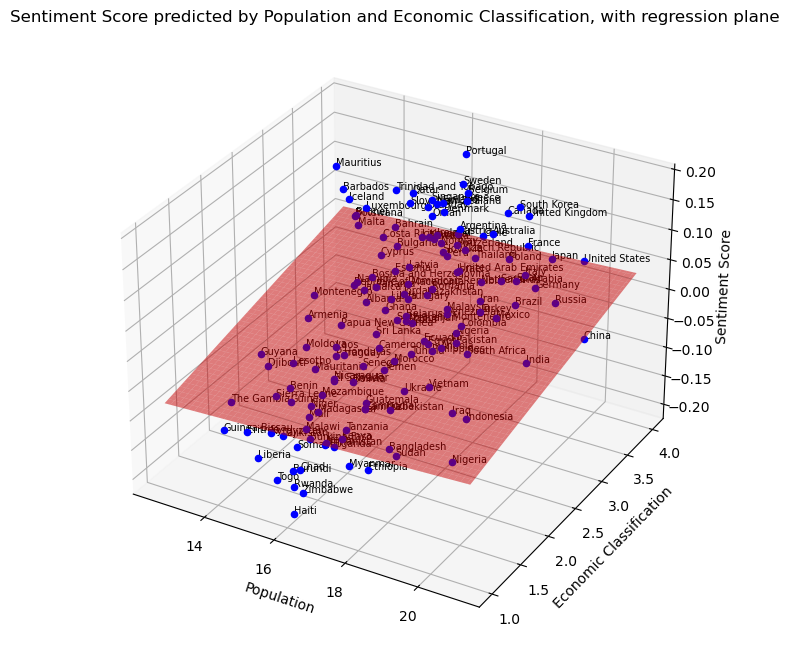

In [55]:
# Re-define the predictor variables (X) and the response variable (y) without adding a constant
X = main_df[['Population', 'Economic classification_dummy']].copy()
X['Population'] = np.log(X['Population'])
y = main_df['sentiment score']
countries = main_df['Country']

# Build the model with a constant
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

# Prepare data for 3D plot
xx, yy = np.meshgrid(np.linspace(X['Population'].min(), X['Population'].max(), 100), 
                     np.linspace(X['Economic classification_dummy'].min(), X['Economic classification_dummy'].max(), 100))
zz = model.params[0] + model.params[1] * xx + model.params[2] * yy

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points and label them
for idx, row in main_df.iterrows():
    ax.scatter(np.log(row['Population']), row['Economic classification_dummy'], row['sentiment score'], color='b', marker='o')
    ax.text(np.log(row['Population']), row['Economic classification_dummy'], row['sentiment score'], '%s' % (row['Country']), size=7, zorder=1)

# Plot the regression plane
ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# Set labels
ax.set_xlabel('Population')
ax.set_ylabel('Economic Classification')
ax.set_zlabel('Sentiment Score')
ax.set_title('Sentiment Score predicted by Population and Economic Classification, with regression plane')

plt.show()

It is clear that Inda and China are population outliers, that do not make up for it with their number of links in, so they should be removed to gain some real insights with our regression analysis.

#### Dealing with outliers

In [56]:
# Exclude outliers
main_df_no_outliers = main_df[(main_df['Country'] != 'China') & (main_df['Country'] != 'India')]

# Re-run the regression without the outliers
X_no_outliers = main_df_no_outliers[['Population', 'Economic classification_dummy', 'region_dummy']]
y_no_outliers = main_df_no_outliers['link_in']

X_no_outliers = sm.add_constant(X_no_outliers)
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()
print(model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     44.48
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           2.50e-20
Time:                        22:46:20   Log-Likelihood:                -928.82
No. Observations:                 146   AIC:                             1866.
Df Residuals:                     142   BIC:                             1878.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

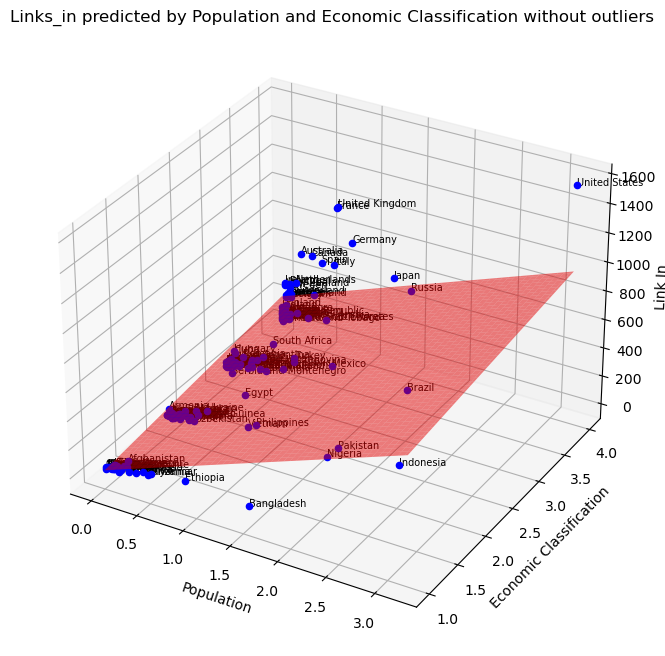

In [57]:
# Prepare data for the 3D plot without the outliers
xx_no_outliers, yy_no_outliers = np.meshgrid(
    np.linspace(X_no_outliers['Population'].min(), X_no_outliers['Population'].max(), 100), 
    np.linspace(X_no_outliers['Economic classification_dummy'].min(), X_no_outliers['Economic classification_dummy'].max(), 100)
)
zz_no_outliers = model_no_outliers.params[0] + model_no_outliers.params[1] * xx_no_outliers + model_no_outliers.params[2] * yy_no_outliers

# Create 3D plot without the outliers
fig_no_outliers = plt.figure(figsize=(10, 8))
ax_no_outliers = fig_no_outliers.add_subplot(111, projection='3d')

# Plot the original data points without the outliers
for idx, row in main_df_no_outliers.iterrows():
    ax_no_outliers.scatter(row['Population'], row['Economic classification_dummy'], row['link_in'], color='b', marker='o')
    ax_no_outliers.text(row['Population'], row['Economic classification_dummy'], row['link_in'], '%s' % (row['Country']), size=7, zorder=1)

# Plot the regression plane without the outliers
ax_no_outliers.plot_surface(xx_no_outliers, yy_no_outliers, zz_no_outliers, color='r', alpha=0.5)

# Set labels
ax_no_outliers.set_xlabel('Population')
ax_no_outliers.set_ylabel('Economic Classification')
ax_no_outliers.set_zlabel('Link In')
ax_no_outliers.set_title('Links_in predicted by Population and Economic Classification without outliers')

plt.show()


Now we see that the $R^2$ correlation coefficient has increased, so we tried the same for sentiment analysis.

In [58]:
# Exclude outliers
main_df_no_outliers = main_df[(main_df['Country'] != 'China') & (main_df['Country'] != 'India')]

# Re-run the regression without the outliers
X_no_outliers = main_df_no_outliers[['Population', 'Economic classification_dummy', 'region_dummy']]
y_no_outliers = main_df_no_outliers['sentiment score']
X_no_outliers = sm.add_constant(X_no_outliers)
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()
print(model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     16.96
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.80e-09
Time:                        22:46:21   Log-Likelihood:                 211.80
No. Observations:                 146   AIC:                            -415.6
Df Residuals:                     142   BIC:                            -403.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Here, there is not a significant improvement removing population outliers. However, due to the coefficients listed, we can see that the majority of the correlation is due to the ```Economic classification_dummy``` variable

Positive Relationship: The coefficient for ```Economic classification_dummy``` is positive (0.0310) and statistically significant (p < 0.001). This indicates that there is a positive association between economic classification and sentiment score. Higher economic classification is associated with a more positive sentiment score.

Model Fit: The R-squared value is 0.264, suggesting that approximately 26.4% of the variance in sentiment scores can be explained by economic classification alone. Although the correlation is not strong it is significant.

Bias Interpretation: The term "bias" in this context is being used to describe a systematic favoritism or skew in sentiment scores towards countries with higher economic classifications. The regression results support the notion that there is a statistically significant association where higher economic classifications correspond to more positive sentiment scores.

Causality Caution: While the model shows an association, it does not prove causality. We cannot say definitively that the higher economic classification causes more positive sentiment without further investigation. Other variables and underlying factors might influence this relationship.

Broader Context: The analysis would benefit from considering additional context, such as the source of the sentiment scores, the methodology used to calculate them, and potential confounding variables that are not included in the model.

In summary, the results suggest that sentiment scores are associated with economic classification, with higher classifications linked to more positive scores. While this could be interpreted as a "bias" towards countries with higher economic classifications, the findings should be understood as indicative of a correlation, not necessarily causation. More comprehensive analysis would be needed to understand the full picture and to explore the reasons behind this association.

#### One-hot Encodigns for Regions: A New Approach

Here, we will perform regression using the region variable again, but this time we will use one hot encoding for the regions. The main_df now contains the updated dataframe with the new binary columns.

In [59]:
# Add 17 new columns to main_df, one for each region
for region in regions:
    # Initialize new columns with 0
    main_df[region] = 0

# Map the 'Region' column to the new binary columns
for idx, row in main_df.iterrows():
    if row['Region'] in regions:
        # Set the corresponding region column to 1
        main_df.at[idx, row['Region']] = 1

In [60]:
# Define the predictor variables (X) and the response variable (y)
# Use the 17 region columns, economic classification, and log of population as predictors
X = main_df.copy()[regions + ['Economic classification_dummy']]
X['Log_Population'] = np.log(main_df['Population'].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0)

X = X.dropna()
X = sm.add_constant(X)
y = main_df.loc[X.index, 'link_in'] # Since we dropped NaN values from X, we need to align y with X
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     19.29
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           4.92e-27
Time:                        22:46:21   Log-Likelihood:                -904.07
No. Observations:                 148   AIC:                             1842.
Df Residuals:                     131   BIC:                             1893.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [61]:
# Define the predictor variables (X) and the response variable (y)
X = main_df.copy()[['Economic classification_dummy']]
X['Log_Population'] = np.log(main_df['Population'].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0)
X = X.dropna()
X = sm.add_constant(X)
y = main_df.loc[X.index, 'link_in']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                link_in   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     62.16
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.20e-20
Time:                        22:46:21   Log-Likelihood:                -947.85
No. Observations:                 148   AIC:                             1902.
Df Residuals:                     145   BIC:                             1911.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [62]:
# Define the predictor variables (X) and the response variable (y)
y = main_df.loc[X.index, 'Article length']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Article length   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     27.03
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.05e-10
Time:                        22:46:21   Log-Likelihood:                -1602.1
No. Observations:                 148   AIC:                             3210.
Df Residuals:                     145   BIC:                             3219.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [63]:
# Define the predictor variables (X) and the response variable (y)
y = main_df.loc[X.index, 'sentiment score']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        sentiment score   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     25.11
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           4.31e-10
Time:                        22:46:21   Log-Likelihood:                 214.44
No. Observations:                 148   AIC:                            -422.9
Df Residuals:                     145   BIC:                            -413.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

From this, we can now see that there is a strong correlation between ```links_in``` and our independent variables, which shows that there is some bias in the game. There is also some correlation between both ```sentiment score``` and ```Article length``` with our independent variables, however this is not as strong. 

Unfortunately, we cannot say that this correlation is definite, as we did not take into consideration the multicollinearity of our independent variables, as well as other factors such as the unseen variables that drive article length, like history, authorship etc. . To fully determine this, extended analysis should consider more variables which extend far beyond the given dataset and our scope.